In [55]:
import numpy as np
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


# Configuration model
def configuration_model(k):
    n = len(k)
    S = np.array([i for i in range(n) for _ in range(k[i])])
    S = np.random.permutation(S)
    if len(S) % 2:
        S = S[:-1]
    S = S.reshape(-1, 2)
    return S


# Sampling with power law distribution
def generate_power_law_degrees(n, gamma=2.3, min_degree=2, max_degree=None):
    if max_degree is None:
        max_degree = n - 1  # Set the maximum degree to n-1 by default
    
    # Use zipf distribution to generate power-law distributed degrees
    k = np.random.zipf(gamma, n)
    
    k = np.clip(k, min_degree, max_degree)

    # Total degree count must be even
    if np.sum(k) % 2 != 0:
        k[-1] += 1
    
    return k


def generate_uniform_degrees(n, mean, min_degree=2, max_degree=None):
    if max_degree is None:
        max_degree = n - 1  # Set the maximum degree to n-1 by default
    
    k = np.random.uniform(min_degree, mean + (mean - min_degree), n)
    k = np.clip(k, min_degree, max_degree)

    # round k to the nearest integer
    k = np.round(k)
    k = k.astype(int)

    # Total degree count must be even
    if np.sum(k) % 2 != 0:
        k[-1] += 1
    
    return k


def convert_to_adjacency_matrix(edges, n):
    A = np.zeros((n, n))
    for edge in edges:
        A[edge[0], edge[1]] = 1
        A[edge[1], edge[0]] = 1
    np.fill_diagonal(A, 0)
    return A


In [56]:
# Score calculation
def calculate_scores_equal(parameters):
    scores = parameters.copy()
    return scores

def calculate_scores_equal_noisy(parameters, noise=0.1):
    scores = parameters.copy()
    scores += np.random.normal(0, noise, scores.shape)
    return scores


# We choose to only update based off copying better performers, as if we do a two-way thing, the fact that you always increase a squared value
# means that inevitably the most connected node far outperforms the rest, and the model seems to be a bad reflection of reality
def update_parameters_linear_naive(scores, parameters, adjacency_matrix, learning_rate=0.1):
    num_nodes = len(scores)
    updated_parameters = np.copy(parameters)
    for i in range(num_nodes):
        update_param_weights_sum = 0
        for j in range(num_nodes):
            # If the parameter of neighbour is higher, we want positive. Same for score
            if adjacency_matrix[i, j] == 1:  # Check if nodes i and j are neighbors
                # neighbour - self
                score_diff = scores[j] - scores[i]
                relative_param = parameters[j] - parameters[i]
                if score_diff > 0:
                    update_param_weights_sum += score_diff * relative_param
        
        updated_parameters[i] += learning_rate * update_param_weights_sum

    updated_parameters = np.minimum(updated_parameters, 1)
    
    return updated_parameters


# Efficient implementation of above
def update_parameters_linear(scores, parameters, adjacency_matrix, learning_rate=0.1):
    # Expand scores to compare each node's score with its neighbors
    score_diff_matrix = adjacency_matrix * (scores - scores[:, np.newaxis])
    
    # set all negative values to 0
    score_diff_matrix = np.maximum(score_diff_matrix, 0)
    # Calculate relative parameters of successful and unsuccessful neighbors for each node
    relative_parameters = adjacency_matrix * (parameters - parameters[:, np.newaxis])
    
    # Elementwise multiplication of score_diff_matrix and relative_parameters
    update_param_weights = score_diff_matrix * relative_parameters

    # Sum the entire row to get the weight update for each node
    update_param_weights_sum = np.sum(update_param_weights, axis=1)

    # Update parameters
    updated_parameters = parameters + learning_rate * update_param_weights_sum
    # If updated parameters are over 1, set them to 1
    updated_parameters = np.minimum(updated_parameters, 1)

    return updated_parameters


# Parameter ppdates
def two_way_update_parameters_linear(scores, parameters, adjacency_matrix, learning_rate=0.1):

    # Expand scores to compare each node's score with its neighbors
    score_diff_matrix = adjacency_matrix * (scores - scores[:, np.newaxis])

    # Calculate relative parameters of successful and unsuccessful neighbors for each node
    relative_parameters = adjacency_matrix * (parameters - parameters[:, np.newaxis])

    # Elementwise multiplication of score_diff_matrix and relative_parameters
    update_param_weights = score_diff_matrix * relative_parameters

    # Sum the entire row to get the weight update for each node
    update_param_weights_sum = np.sum(update_param_weights, axis=1)

    updated_parameters = parameters + learning_rate * update_param_weights_sum

    # Comment out to illustrate large growth
    # updated_parameters = np.minimum(updated_parameters, 1)

    return updated_parameters



In [57]:
# Compare the two implementations on a smaller scale
n = 1000
gamma = 2.3
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A_test = convert_to_adjacency_matrix(edges, n)
np.fill_diagonal(A_test, 0)
parameters = np.random.rand(n)
parameters2 = parameters.copy()
scores = calculate_scores_equal(parameters)
scores2 = calculate_scores_equal(parameters2)

%timeit update_parameters_linear_naive(scores, parameters, A_test)
%timeit update_parameters_linear(scores, parameters, A_test)

assert np.allclose(update_parameters_linear_naive(scores, parameters, A_test), update_parameters_linear(scores2, parameters2, A_test))

81.5 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.68 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
# Figure 1: Comparing network size and average score increase over generations
# network_sizes = [100, 500, 1000, 5000]
# num_generations = 100

# Smaller size for testing
network_sizes = [10, 50, 100, 500]
num_generations = 100

# Parameters
gamma = 2.3
num_runs = 50

def run_simulation_base(network_sizes, gamma, num_generations, num_runs, restricted_degree=True, param_distribution='uniform'):
    average_scores_all_runs = {n: [] for n in network_sizes}
    mean_degrees_all_runs = {n: [] for n in network_sizes}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        if param_distribution == 'uniform':
            base_parameters = np.random.rand(network_sizes[0])
        elif param_distribution == 'power_law':
            # Adjusted by a factor of 4 to make the parameters more similar to the uniform distribution
            base_parameters = np.random.zipf(2.3, size=network_sizes[0]) / 3.8
        elif param_distribution == 'gaussian_low_noise':
            base_parameters = np.random.normal(0.5, 0.1, network_sizes[0])
            base_parameters = np.clip(base_parameters, 0, 1)
        else:
            base_parameters = np.random.normal(0.5, 0.5, network_sizes[0])
            base_parameters = np.clip(base_parameters, 0, 1)
        
        base_degrees = generate_power_law_degrees(network_sizes[0], gamma)
        
        for n in network_sizes:
            if restricted_degree:
                # Restrict max_degree to 100 to aid comparison across network sizes
                degrees = np.tile(base_degrees, n//network_sizes[0])
            else:
                degrees = generate_power_law_degrees(n, gamma)

            mean_degrees_all_runs[n].append(np.mean(degrees))
            edges = configuration_model(degrees)
            A = convert_to_adjacency_matrix(edges, n)
            np.fill_diagonal(A, 0)
            
            # Make n/network_sizes[0] copies of the base parameters
            parameters = np.tile(base_parameters, n//network_sizes[0])
            scores = calculate_scores_equal(parameters)
            
            average_scores_n = []
            
            for i in range(num_generations):
                parameters = update_parameters_linear(scores, parameters, A)
                scores = calculate_scores_equal(parameters)
                average_scores_n.append(np.mean(scores))
            
            average_scores_all_runs[n].append(average_scores_n)

    # Compute the mean across all runs for each network size and generation
    final_average_scores = {n: np.mean(average_scores_all_runs[n], axis=0) for n in network_sizes}

    return final_average_scores, mean_degrees_all_runs

In [69]:
dc_final_average_scores, dc_mean_degrees_all_runs = run_simulation_base(network_sizes, gamma, num_generations, num_runs)

100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


In [70]:
dc_pl_final_average_scores, dc_pl_mean_degrees_all_runs = run_simulation_base(network_sizes, gamma, num_generations, num_runs, param_distribution='power_law')

100%|██████████| 50/50 [00:04<00:00, 11.14it/s]


In [71]:
dc_gl_final_average_scores, dc_gl_mean_degrees_all_runs = run_simulation_base(network_sizes, gamma, num_generations, num_runs, param_distribution='gaussian_low_noise')

100%|██████████| 50/50 [00:03<00:00, 12.94it/s]


In [72]:
dc_gh_final_average_scores, dc_gh_noise_mean_degrees_all_runs = run_simulation_base(network_sizes, gamma, num_generations, num_runs, param_distribution='gaussian_high_noise')

100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


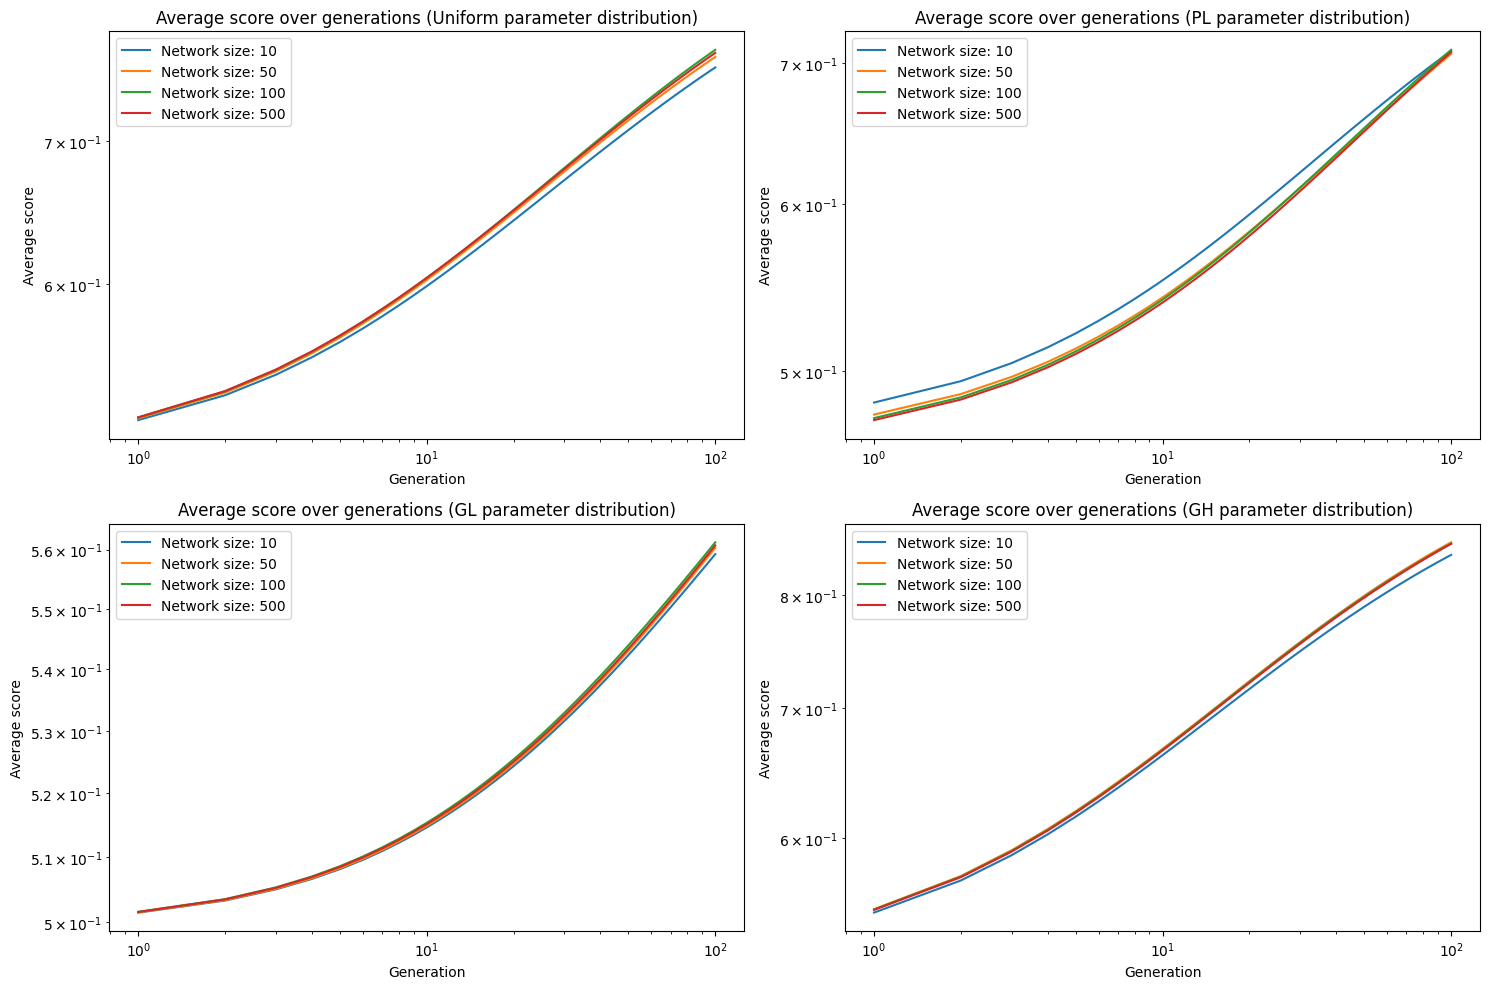

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
datasets = [dc_final_average_scores, dc_pl_final_average_scores, dc_gl_final_average_scores, dc_gh_final_average_scores]
titles = ['Uniform parameter distribution', 'PL parameter distribution', 'GL parameter distribution', 'GH parameter distribution']

for ax, data, title in zip(axs.flat, datasets, titles):
    for n in network_sizes:
        ax.plot(range(1, num_generations + 1), data[n], label=f'Network size: {n}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Average score')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Average score over generations ({title})')
    ax.legend()

plt.tight_layout()
plt.show()

# Unrestricted Degree (Appendix)

In [75]:
nu_final_average_scores, nu_mean_degrees_all_runs = run_simulation_base(network_sizes, gamma, num_generations, num_runs, restricted_degree=False)

100%|██████████| 50/50 [00:03<00:00, 12.97it/s]


{10: 2.524, 50: 2.524, 100: 2.524, 500: 2.524}
{10: 2.5039999999999996, 50: 2.8991999999999996, 100: 2.9812, 500: 3.2471199999999993}


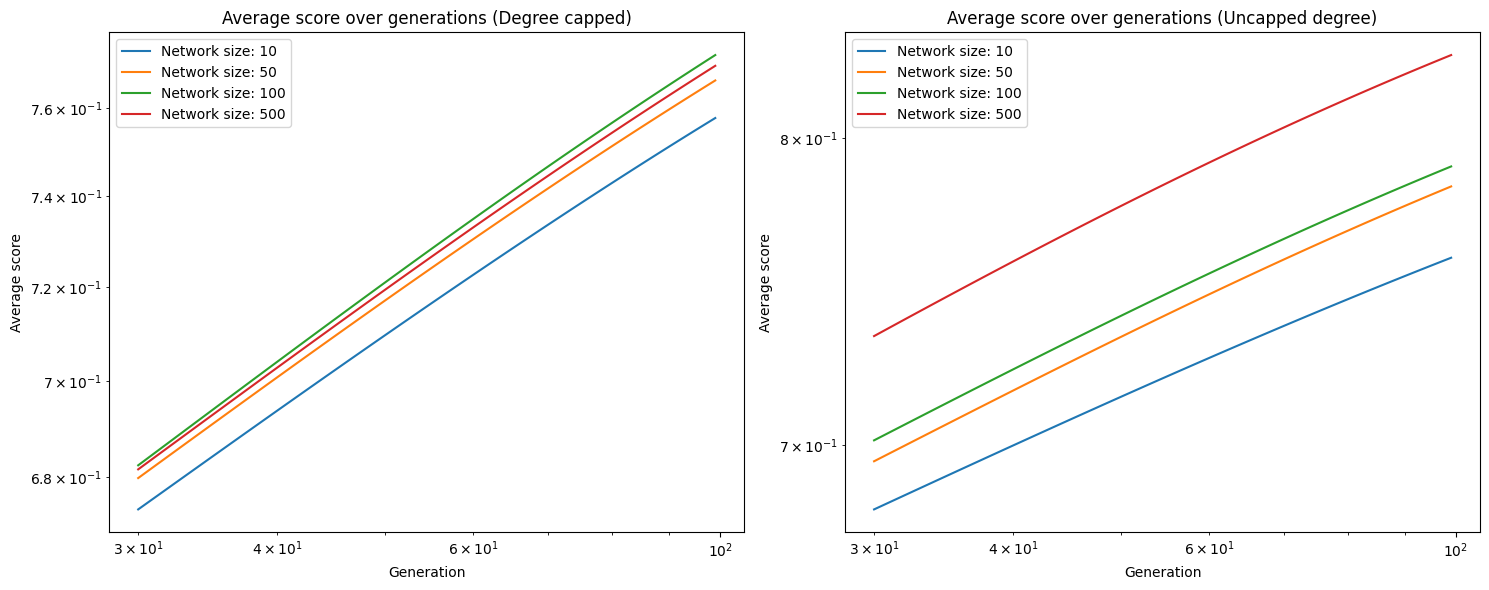

In [76]:
mean_degrees = {n: np.mean(dc_mean_degrees_all_runs[n]) for n in network_sizes}
print(mean_degrees)
mean_degrees = {n: np.mean(nu_mean_degrees_all_runs[n]) for n in network_sizes}
print(mean_degrees)
# plot dc and nu in the same figure in two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
datasets = [dc_final_average_scores, nu_final_average_scores]
titles = ['Degree capped', 'Uncapped degree']

for ax, data, title in zip(axs.flat, datasets, titles):
    for n in network_sizes:
        # Only take from gen 30 onwards to make differences clearer
        ax.plot(range(30, num_generations), data[n][30:], label=f'Network size: {n}')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Average score')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Average score over generations ({title})')
    ax.legend()

plt.tight_layout()
plt.show()

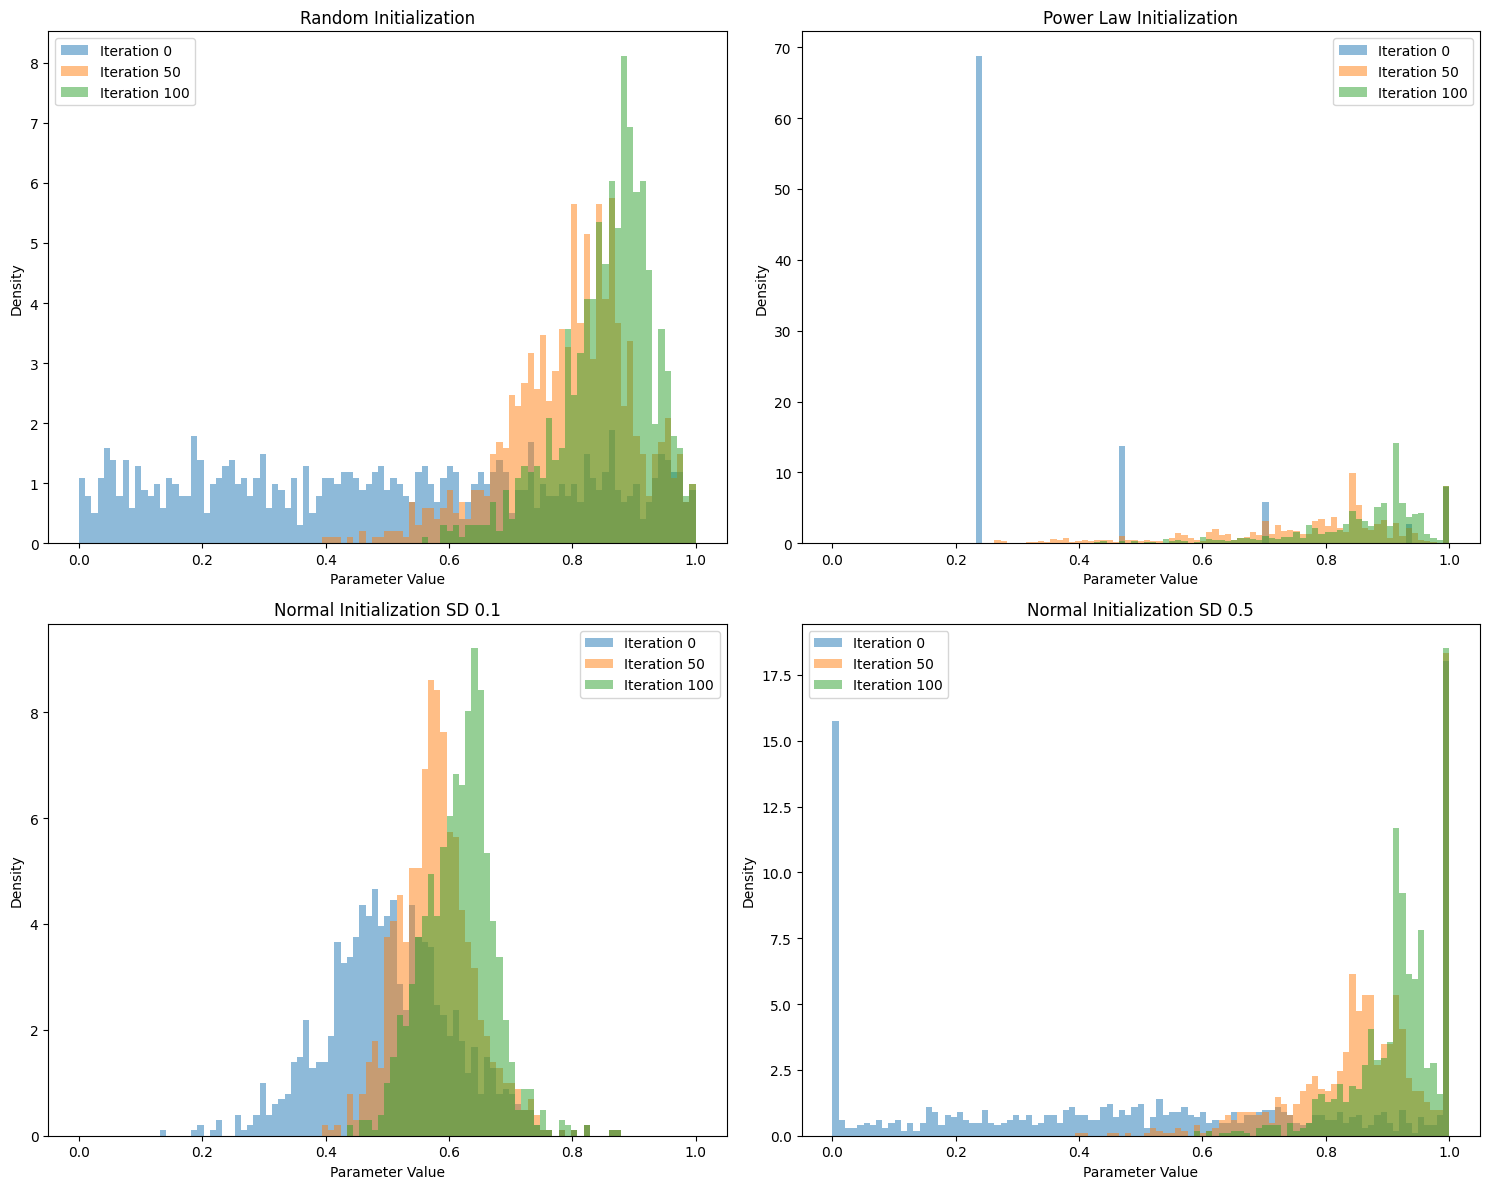

In [77]:
# Figure 2: Comparing different parameter initializations
# Overlay specific iterations of parameter distributions
n = 1000 
gamma = 2.3  

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

initializations = [
    ("Random Initialization", np.random.rand(n)),
    ("Power Law Initialization", np.random.zipf(2.3, size=n)/4.3),
    ("Normal Initialization SD 0.1", np.random.normal(0.5, 0.1, n)),
    ("Normal Initialization SD 0.5", np.random.normal(0.5, 0.5, n))
]

# Clip the parameters and print the number of parameters at 0 and 1
initializations = [
    (title, np.clip(parameters, 0, 1)) for title, parameters in initializations
]

iterations_to_plot = [0, 50, 100]  # Iterations 0, 50, and 100 (0-indexed)
bins = np.linspace(0, 1, 100)

# Set up the plot with 4 subfigures
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

for ax, (title, parameters) in zip(axs, initializations):
    for i in range(101):
        if i in iterations_to_plot:
            # Overlay parameter distribution
            ax.hist(parameters, bins=bins, density=True, alpha=0.5, label=f'Iteration {i}')
        scores = calculate_scores_equal(parameters)
        parameters = update_parameters_linear(scores, parameters, A)



    # Add titles and labels
    ax.set_title(title)
    ax.set_xlabel("Parameter Value")
    ax.set_ylabel("Density")
    ax.legend()

plt.tight_layout()
plt.show()

# Two-way demonstration (Appendix)

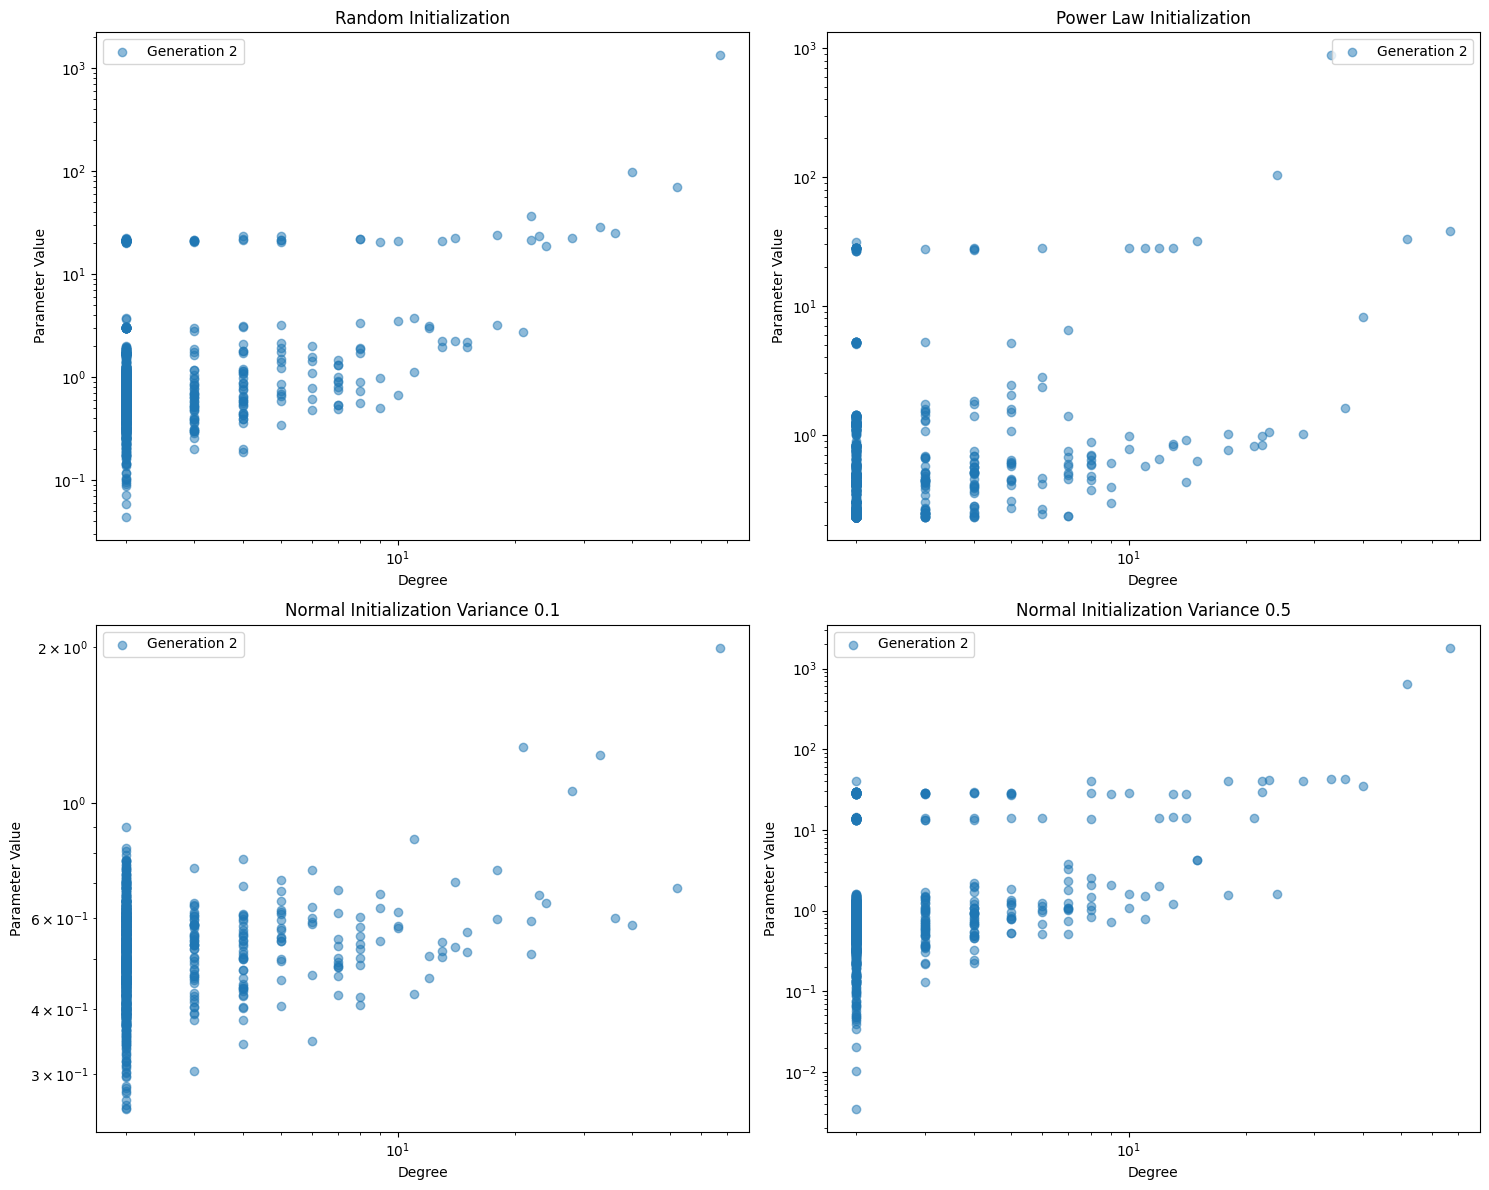

In [86]:
n = 1000 
gamma = 2.3  

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

initializations = [
    ("Random Initialization", np.random.rand(n)),
    ("Power Law Initialization", np.random.zipf(2.3, size=n)/4.3),
    ("Normal Initialization Variance 0.1", np.random.normal(0.5, 0.1, n)),
    ("Normal Initialization Variance 0.5", np.random.normal(0.5, 0.5, n))
]

# Clip the parameters
initializations = [
    (title, np.clip(parameters, 0, 1)) for title, parameters in initializations
]

generation_to_plot = 2

# Set up the plot with 4 subfigures
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
axs = axs.flatten()

for ax, (title, parameters) in zip(axs, initializations):
    for i in range(generation_to_plot + 1):
        scores = calculate_scores_equal(parameters)
        parameters = two_way_update_parameters_linear(scores, parameters, A)
        if i == generation_to_plot:
            ax.scatter(degrees, parameters, alpha=0.5, label=f'Generation {i}')

    # Add titles and labels
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Parameter Value")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
plt.show()







# Addition of Noise

100%|██████████| 1000/1000 [00:14<00:00, 71.11it/s]


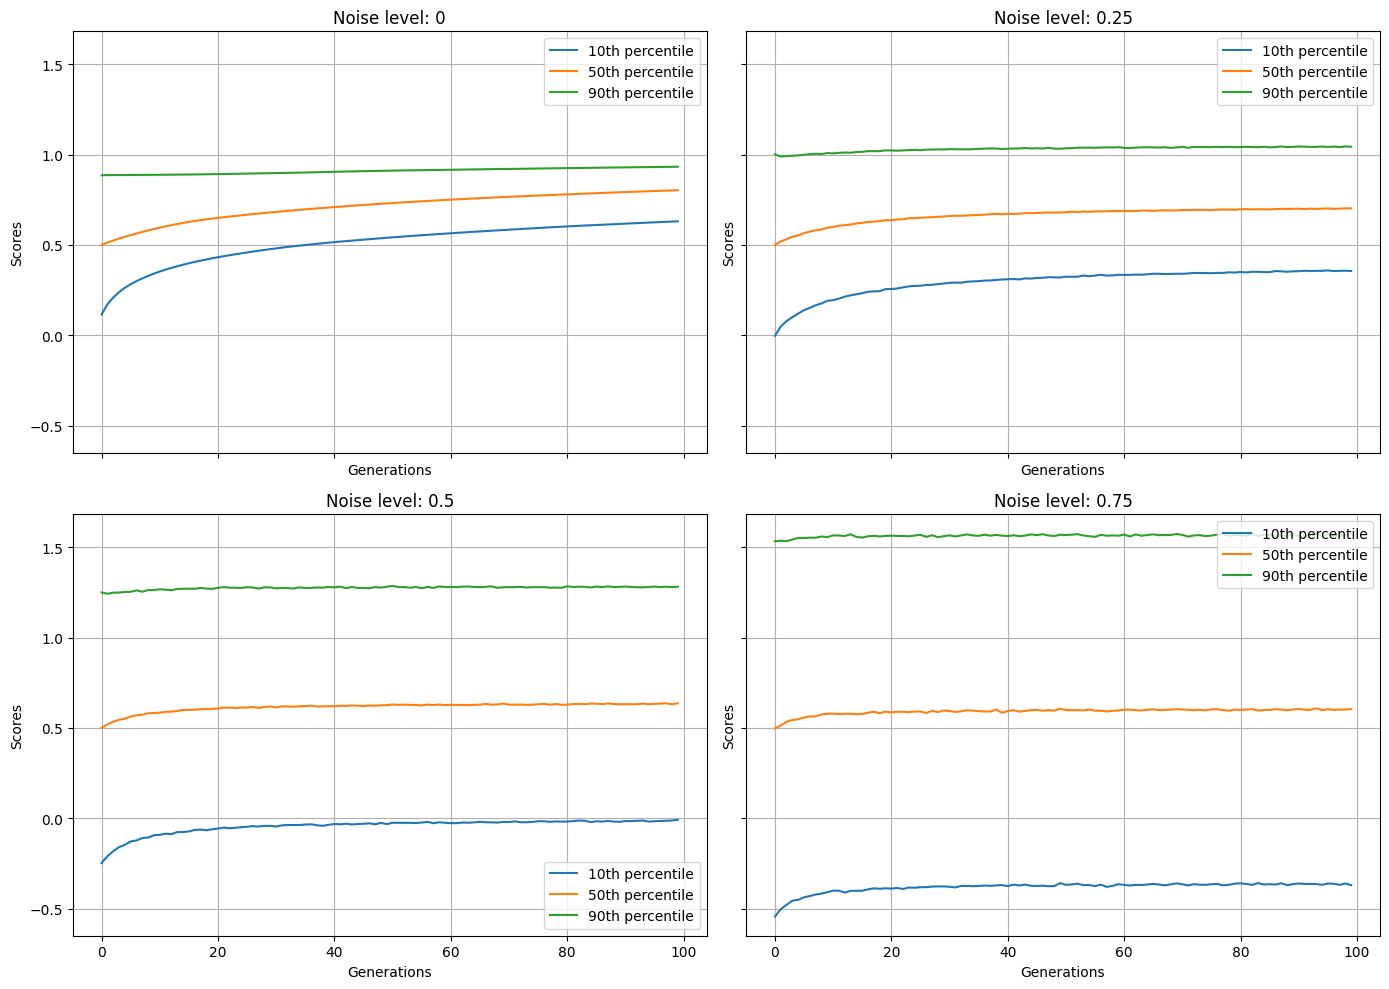

In [88]:
# n = 1000
# gamma = 2.3

# Smaller for testing
n = 100
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
num_generations = 100
num_runs = 1000
noise_levels = [0, 0.25, 0.5, 0.75]


all_scores = {noise: np.zeros((num_runs, num_generations, n)) for noise in noise_levels}

# Repeat the operation for num_runs times
for run in tqdm(range(num_runs)):
    for noise in noise_levels:
        # Initialize with the same distribution for all noise levels
        parameters = np.random.normal(0.5, 0.3, n)
        for i in range(num_generations):
            scores = calculate_scores_equal_noisy(parameters, noise)
            parameters = update_parameters_linear(scores, parameters, A)
            all_scores[noise][run, i, :] = scores

# Calculate the percentiles
percentiles = {noise: np.zeros((num_generations, 3)) for noise in noise_levels}
for noise in noise_levels:
    for i in range(num_generations):
        percentiles[noise][i, 0] = np.percentile(all_scores[noise][:, i, :], 10)
        percentiles[noise][i, 1] = np.percentile(all_scores[noise][:, i, :], 50)
        percentiles[noise][i, 2] = np.percentile(all_scores[noise][:, i, :], 90)

# Plotting the percentiles over generations for different noise levels
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, noise in enumerate(noise_levels):
    axes[idx].plot(range(num_generations), percentiles[noise][:, 0], label='10th percentile')
    axes[idx].plot(range(num_generations), percentiles[noise][:, 1], label='50th percentile')
    axes[idx].plot(range(num_generations), percentiles[noise][:, 2], label='90th percentile')
    axes[idx].set_title(f'Noise level: {noise}')
    axes[idx].set_xlabel('Generations')
    axes[idx].set_ylabel('Scores')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()



In [89]:
# print averages of above plot
for noise in [0, 0.25, 0.5, 0.75]:
    print(f"Noise: {noise}")
    print(percentiles[noise][:, 0][-1])
    print(percentiles[noise][:, 1][-1])
    print(percentiles[noise][:, 2][-1])

Noise: 0
0.6305903046665383
0.8024765294079538
0.9324366777236157
Noise: 0.25
0.3558572899899514
0.7019145039847046
1.0430552740757615
Noise: 0.5
-0.007404040272344512
0.6367006397669477
1.2812247403391583
Noise: 0.75
-0.36909717206701764
0.6040820415333031
1.5735923961672758


# Referral Mechanism

In [90]:
def get_highest_scoring_neighbor(adj_matrix, node_scores, node):
    neighbors = np.where(adj_matrix[node] == 1)[0]
    if len(neighbors) == 0:
        #print("No neighbors")
        return None
    highest_neighbor = neighbors[np.argmax([node_scores[n] for n in neighbors])]
    return highest_neighbor

def reshuffle_matrix(adj_matrix, node_scores, referral_rate, min_degree=0):
    num_nodes = len(adj_matrix)
    new_adj_matrix = np.copy(adj_matrix)
    reshuffled_nodes = []
    for node in range(num_nodes):
        if random.random() <= referral_rate:
            highest_neighbor = get_highest_scoring_neighbor(adj_matrix, node_scores, node)
            
            neighbors = np.where(adj_matrix[node] == 1)[0]
            if len(neighbors) == 0:
                continue
            
            neighbors_of_neighbor = neighbors[neighbors != highest_neighbor]
            if len(neighbors_of_neighbor) == 0:
                continue
            random_neighbor = random.choice(neighbors_of_neighbor)

            random_neighbor_neighbors = np.where(adj_matrix[random_neighbor] == 1)[0]
            
            if len(random_neighbor_neighbors) <= 1:
                continue

            
            remove_candidate = random.choice(random_neighbor_neighbors[random_neighbor_neighbors != node])
            
            if len(np.where(adj_matrix[remove_candidate] == 1)[0]) <= min_degree:
                continue

            if new_adj_matrix[random_neighbor, remove_candidate] == 1 and new_adj_matrix[random_neighbor, highest_neighbor] == 0:
                if remove_candidate != highest_neighbor:
                    new_adj_matrix[random_neighbor, remove_candidate] = 0
                    new_adj_matrix[remove_candidate, random_neighbor] = 0
                    
                    new_adj_matrix[random_neighbor, highest_neighbor] = 1
                    new_adj_matrix[highest_neighbor, random_neighbor] = 1

                    reshuffled_nodes.append([random_neighbor, remove_candidate, highest_neighbor])


    return new_adj_matrix, reshuffled_nodes

In [91]:
# test reshuffle matrix by comparing it to the old one
n = 10
gamma = 2.3
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)
scores = np.random.rand(n)
referral_rate = 0.9

# print degrees before
degrees = np.sum(A, axis=1)
degrees_m = np.mean(np.sum(A, axis=1))
#print(degrees)
print(f"original mean degree {degrees_m}")
new_A, reshuffled_nodes = reshuffle_matrix(A, scores, referral_rate)
print(f"Nodes reshuffled: {reshuffled_nodes}")
print(f"Number of nodes reshuffled: {len(reshuffled_nodes)}")
# print degrees after
new_degrees = np.sum(new_A, axis=1)
new_degrees_m = np.mean(np.sum(new_A, axis=1))
#print(new_degrees)
print(f"new mean degree {new_degrees_m}")

assert not np.allclose(A, new_A)

original mean degree 1.6
Nodes reshuffled: [[7, 6, 9], [3, 9, 5], [2, 5, 9], [8, 6, 2], [7, 1, 8], [1, 9, 6]]
Number of nodes reshuffled: 6
new mean degree 1.6


# Generate Figures

In [92]:
# For the same noise levels, network sizes, and generations, compare the effect of changing the referral rate
# n = 5000
# gamma = 2.3

# Smaller size for testing
n = 100
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
# We take 100 gens here as for a network of this size, past 100 generations the scores are already converging and don't show much interesting behaviour
num_generations = 100
num_runs = 50
referral_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def run_simulation_referral_percentiles(A, num_generations, num_runs, referral_rates, min_degree=0, noise=0):
    # Initialize lists to store average scores and percentiles
    average_scores_all_runs = {rate: np.zeros(num_generations) for rate in referral_rates}
    percentile_scores_all_runs = {rate: {10: np.zeros(num_generations), 50: np.zeros(num_generations), 90: np.zeros(num_generations)} for rate in referral_rates}
    all_scores_per_gen = {rate: [[] for _ in range(num_generations)] for rate in referral_rates}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        base_parameters = np.random.normal(0.5, 0.3, n)
        for rate in referral_rates:
            parameters = base_parameters.copy()
            adjacency_matrix = A.copy()
            for i in range(num_generations):
                if noise == 0:
                    scores = calculate_scores_equal(parameters)
                else:
                    scores = calculate_scores_equal_noisy(parameters, noise)
                parameters = update_parameters_linear(scores, parameters, adjacency_matrix)

                adjacency_matrix, _ = reshuffle_matrix(adjacency_matrix, scores, referral_rate=rate, min_degree=min_degree)

                average_scores_all_runs[rate][i] += np.mean(scores)
                all_scores_per_gen[rate][i].extend(scores)
    
    # Calculate the average scores and percentiles over all runs
    for rate in referral_rates:
        average_scores_all_runs[rate] /= num_runs
        for i in range(num_generations):
            if len(all_scores_per_gen[rate][i]) > 0:
                percentile_scores_all_runs[rate][10][i] = np.percentile(all_scores_per_gen[rate][i], 10)
                percentile_scores_all_runs[rate][50][i] = np.percentile(all_scores_per_gen[rate][i], 50)
                percentile_scores_all_runs[rate][90][i] = np.percentile(all_scores_per_gen[rate][i], 90)
            else:
                percentile_scores_all_runs[rate][10][i] = np.nan
                percentile_scores_all_runs[rate][50][i] = np.nan
                percentile_scores_all_runs[rate][90][i] = np.nan

    return average_scores_all_runs, percentile_scores_all_runs

average_scores, percentile_scores = run_simulation_referral_percentiles(A, num_generations, num_runs, referral_rates)


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


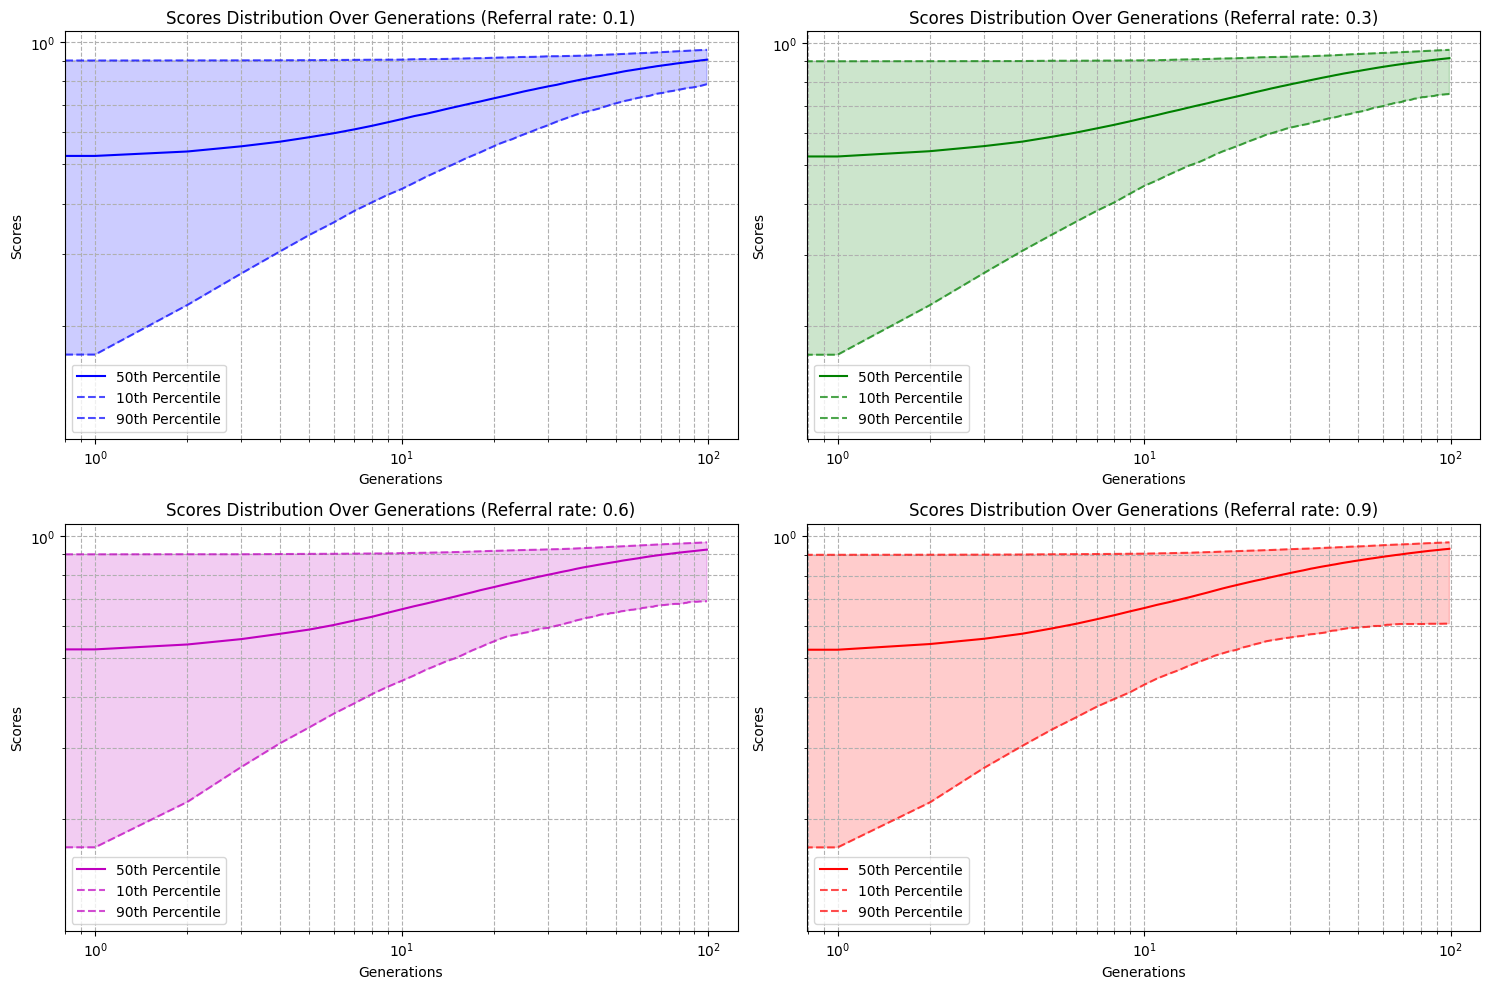

In [93]:
# Select the referral rates to plot
selected_rates = [0.1, 0.3, 0.6, 0.9]
colors = {0.1: 'b', 0.3: 'g', 0.6: 'm', 0.9: 'r'}  # Define colors for each referral rate

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, rate in enumerate(selected_rates):
    ax = axes[i // 2, i % 2]
    generations = range(num_generations)
    
    # Prepare scores for plotting on log-log scale
    adjusted_10th_percentile = percentile_scores[rate][10]
    adjusted_50th_percentile = percentile_scores[rate][50]
    adjusted_90th_percentile = percentile_scores[rate][90]
    
    ax.plot(generations, adjusted_50th_percentile, label=f'50th Percentile', color=colors[rate])
    ax.fill_between(generations, 
                    adjusted_10th_percentile, 
                    adjusted_90th_percentile, 
                    color=colors[rate], 
                    alpha=0.2)
    ax.plot(generations, adjusted_10th_percentile, linestyle='--', color=colors[rate], alpha=0.7, label=f'10th Percentile')
    ax.plot(generations, adjusted_90th_percentile, linestyle='--', color=colors[rate], alpha=0.7, label=f'90th Percentile')
    
    ax.set_xlabel('Generations')
    ax.set_ylabel('Scores')
    # log scale on both axes
    ax.set_xscale('log')  
    ax.set_yscale('log')  
    ax.set_title(f'Scores Distribution Over Generations (Referral rate: {rate})')
    ax.legend()
    ax.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


In [94]:
# n = 500
# gamma = 2.3

# Small network for testing
n = 50
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
num_generations = 200
num_runs = 100
referral_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def run_simulation_referral_score_ref_rate_filter(A, num_generations, num_runs, referral_rates, min_degree=0, noise=0):
    # Initialize lists to store average scores at different points
    # Empirical points around where we hit the thresholds of 0.6, 0.7, 0.8, 0.9 for this network
    points = [15, 35, 100, 150]
    average_scores_all_runs = {rate: np.zeros((4,)) for rate in referral_rates}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        base_parameters = np.random.normal(0.5, 0.2, len(A))
        for rate in referral_rates:
            parameters = base_parameters.copy()
            adjacency_matrix = A.copy()
            for i in range(num_generations):
                if noise == 0:
                    scores = calculate_scores_equal(parameters)
                else:
                    scores = calculate_scores_equal_noisy(parameters, noise)
                parameters = update_parameters_linear(scores, parameters, adjacency_matrix)
                adjacency_matrix, _ = reshuffle_matrix(adjacency_matrix, scores, rate, min_degree)

                if i in points:
                    index = points.index(i)
                    average_scores_all_runs[rate][index] += np.mean(scores)

    # Calculate the average scores over all runs
    for rate in referral_rates:
        average_scores_all_runs[rate] /= num_runs

    return average_scores_all_runs

In [95]:
# Run the modified simulation
four_average_scores = run_simulation_referral_score_ref_rate_filter(A, num_generations, num_runs, referral_rates)

100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


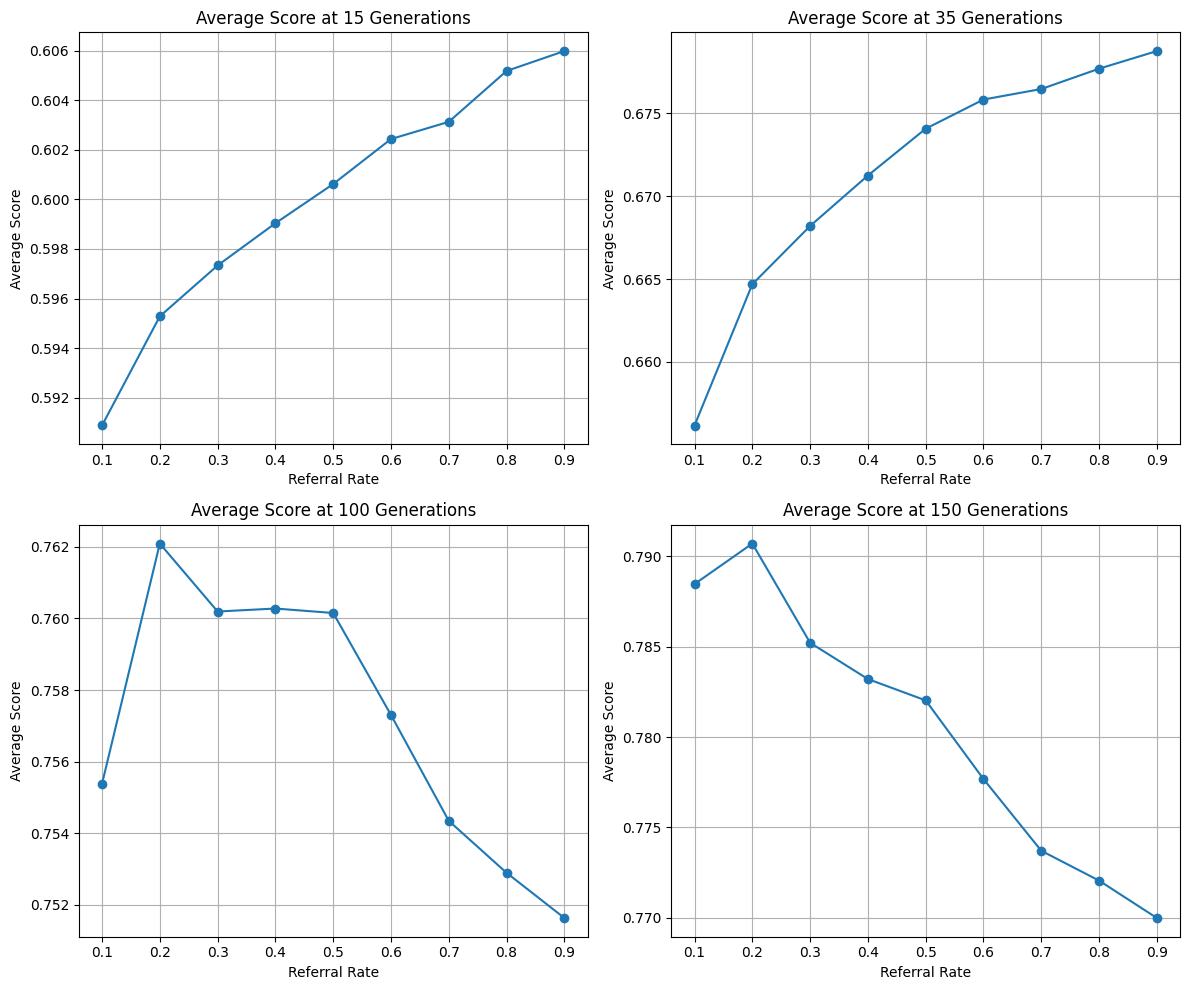

In [96]:
points_labels = ['15', '35', '100', '150']

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plotting the data
for idx, point_label in enumerate(points_labels):
    axs[idx].plot(referral_rates, [four_average_scores[rate][idx] for rate in referral_rates], marker='o')
    axs[idx].set_title(f'Average Score at {point_label} Generations')
    axs[idx].set_xlabel('Referral Rate')
    axs[idx].set_ylabel('Average Score')
    axs[idx].grid(True)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [97]:
n = 500
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
num_generations = 200
num_runs = 1
referral_rates = [0.1, 0.9]
def run_simulation_referral_distribution_slice(A, num_generations, num_runs, referral_rates, sd, min_degree=0, noise=0):
    checkpoints = [15, 35, 100, 150]
    score_distribution = {rate: {checkpoint: np.zeros(n) for checkpoint in checkpoints} for rate in referral_rates}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        base_parameters = np.random.normal(0.5, sd, n)
        for rate in referral_rates:
            parameters = base_parameters.copy()
            adjacency_matrix = A.copy()
            # This ensures that the highest scoring node is always the same
            highest_scoring_index = np.argmax(parameters)
            for i in range(num_generations):
                if noise == 0:
                    scores = calculate_scores_equal(parameters)
                else:
                    scores = calculate_scores_equal_noisy(parameters, noise)
                parameters = update_parameters_linear(scores, parameters, adjacency_matrix)

                adjacency_matrix, reshuffled_nodes = reshuffle_matrix(adjacency_matrix, scores, referral_rate=rate)

                # Store score distribution at the checkpoints
                if i in checkpoints and run == 0:
                    score_distribution[rate][i] = parameters.copy()

    return score_distribution



In [98]:
score_distribution_slice = run_simulation_referral_distribution_slice(A, num_generations, num_runs, referral_rates, 0.2)

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


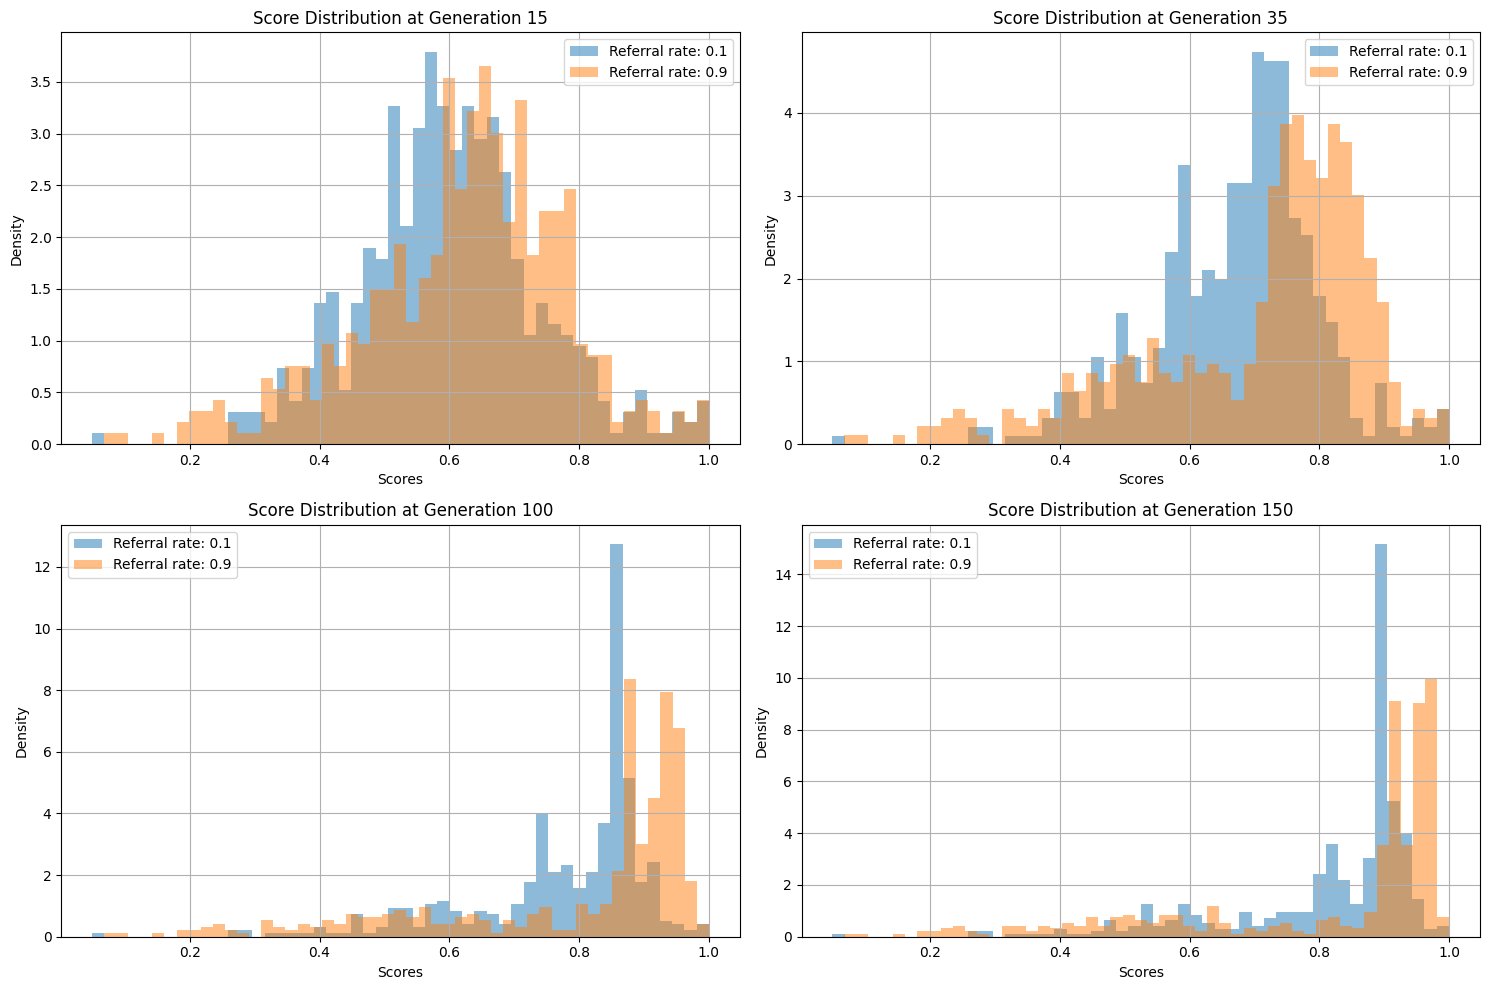

In [99]:
# Plot histogram slices of scores of 0.1 and 0.9 overlaid at 4 different time points 25%, 50%, 75%, 100%

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, checkpoint in enumerate([15, 35, 100, 150]):
    ax = axes[i // 2, i % 2]
    for rate in [0.1, 0.9]:
        ax.hist(score_distribution_slice[rate][checkpoint], bins=50, alpha=0.5, label=f'Referral rate: {rate}', density=True)
    ax.set_title(f'Score Distribution at Generation {checkpoint}')
    ax.set_xlabel('Scores')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Parameter Initialization with SD = 0.2
Enforcing min degree affects trend, possibly because of the slowed improvement of the network

In [100]:
# plot average scores for a certain generation for different distributions. Base gaussian, uniform, restricted degree 2, restricted degree 3

n = 500
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
num_generations = 100
num_runs = 50
referral_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def run_simulation_referral_score_ref_rate(A, num_generations, num_runs, referral_rates, min_degree=0, noise=0):
    # Initialize lists to store average scores
    average_scores_all_runs = {rate: np.zeros(num_generations) for rate in referral_rates}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        # 0.2 standard deviation showed the first signs of a changing trend in average scores as it was in the 
        # sweet spot for generations, hitting the 0.75-0.8 range within 100 generations
        base_parameters = np.random.normal(0.5, 0.2, n)
        for rate in referral_rates:
            parameters = base_parameters.copy()
            adjacency_matrix = A.copy()
            for i in range(num_generations):
                if noise == 0:
                    scores = calculate_scores_equal(parameters)
                else:
                    scores = calculate_scores_equal_noisy(parameters, noise)
                parameters = update_parameters_linear(scores, parameters, adjacency_matrix)

                adjacency_matrix, _ = reshuffle_matrix(adjacency_matrix, scores, rate, min_degree)

                average_scores_all_runs[rate][i] += np.mean(scores)
        

    # Calculate the average scores over all runs
    for rate in referral_rates:
        average_scores_all_runs[rate] /= num_runs

    return average_scores_all_runs

In [101]:
avg_2_scores_base_gaussian = run_simulation_referral_score_ref_rate(A, num_generations, num_runs, referral_rates, min_degree=0, noise=0)
avg_2_scores_restricted_2 = run_simulation_referral_score_ref_rate(A, num_generations, num_runs, referral_rates, min_degree=2, noise=0)
avg_2_scores_restricted_3 = run_simulation_referral_score_ref_rate(A, num_generations, num_runs, referral_rates, min_degree=3, noise=0)

100%|██████████| 50/50 [02:18<00:00,  2.77s/it]


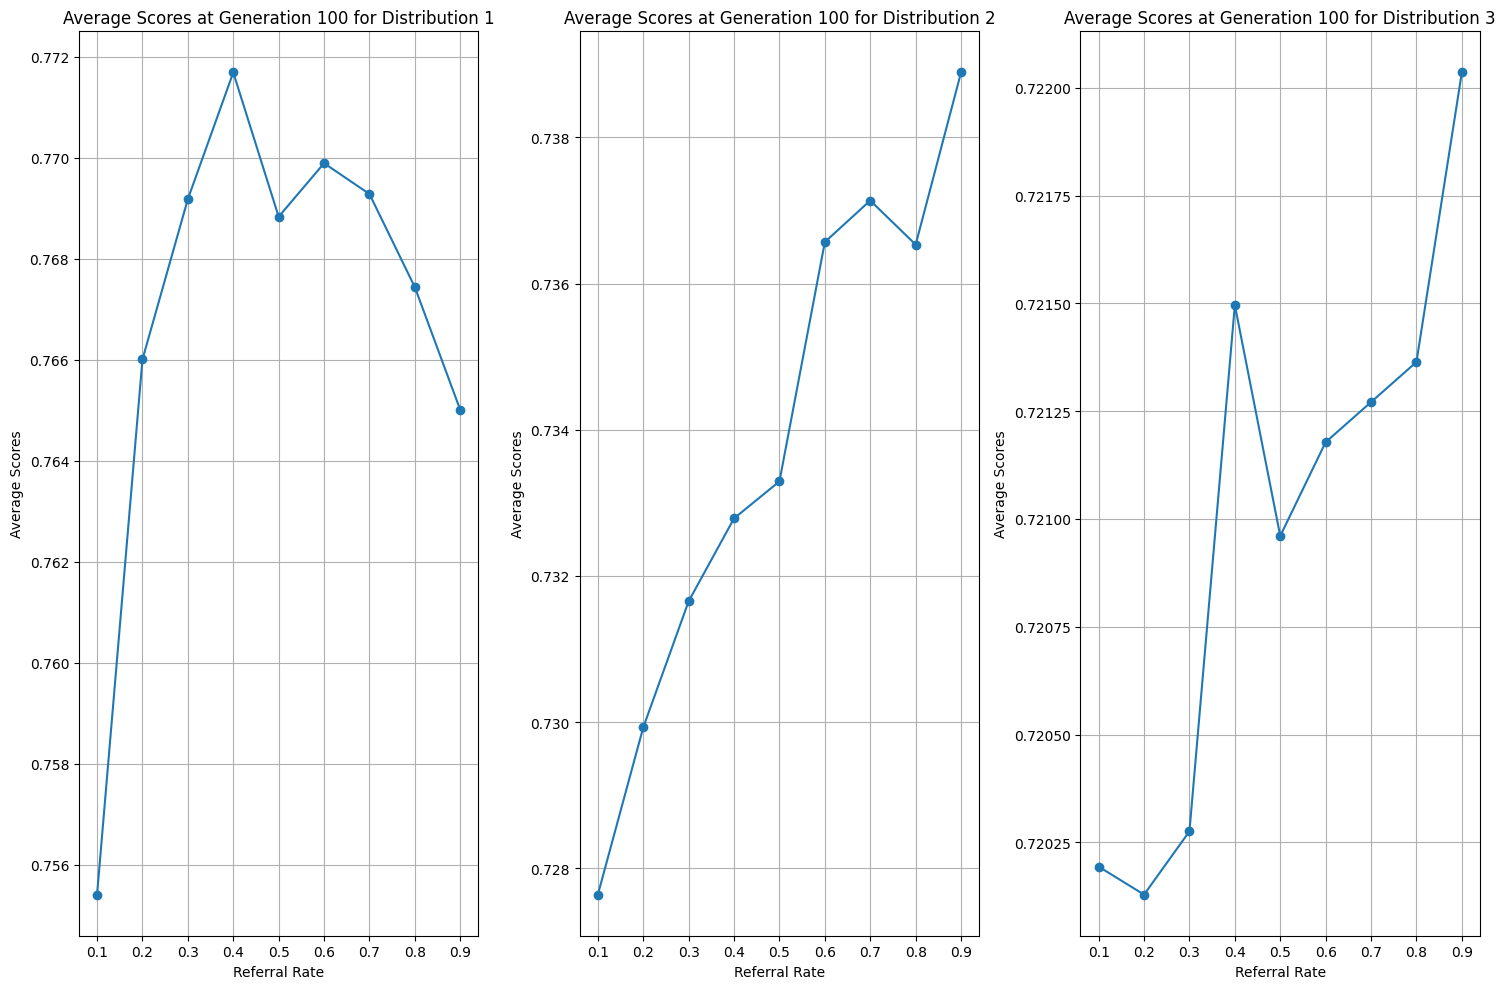

In [102]:
# plot the average scores for different distributions over referral rates on different subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for i, avg_scores in enumerate([avg_2_scores_base_gaussian, avg_2_scores_restricted_2, avg_2_scores_restricted_3]):
    ax = axes[i]
    ax.plot(referral_rates, [avg_scores[rate][-1] for rate in referral_rates], marker='o')
    ax.set_xlabel('Referral Rate')
    ax.set_ylabel('Average Scores')
    ax.set_title(f'Average Scores at Generation 100 for Distribution {i+1}')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Deeper Exploration

We define a full simulation function below to explore any extra characteristics we want to find out more about in each distribution: some interesting ones are shown below

In [ ]:
# For the same noise levels, network sizes, and generations, compare the effect of changing the referral rate
n = 500
gamma = 2.3

# Generate power-law distributed degree sequence
degrees = generate_power_law_degrees(n, gamma)
edges = configuration_model(degrees)
A = convert_to_adjacency_matrix(edges, n)

# Parameters
num_generations = 200
num_runs = 50
referral_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def run_simulation_referral(A, num_generations, num_runs, referral_rates, min_degree=0, noise=0):
    # Initialize lists to store average scores
    average_scores_all_runs = {rate: np.zeros(num_generations) for rate in referral_rates}
    final_scores_all_runs = {rate: np.zeros(n) for rate in referral_rates}
    average_degree_before = {rate: np.zeros(num_generations) for rate in referral_rates}
    average_degree_after = {rate: np.zeros(num_generations) for rate in referral_rates}
    number_of_reshuffled_nodes = {rate: np.zeros(num_generations) for rate in referral_rates}
    degree_highest_scoring_node = {rate: np.zeros(num_generations) for rate in referral_rates} 
    degree_distribution = {rate: np.zeros(n) for rate in referral_rates}

    # Repeat the operation for num_runs times
    for run in tqdm(range(num_runs)):
        base_parameters = np.random.normal(0.5, 0.3, n)
        for rate in referral_rates:
            parameters = base_parameters.copy()
            adjacency_matrix = A.copy()
            # This ensures that the highest scoring node is always the same
            highest_scoring_index = np.argmax(parameters)
            for i in range(num_generations):
                if noise == 0:
                    scores = calculate_scores_equal(parameters)
                else:
                    scores = calculate_scores_equal_noisy(parameters, noise)
                parameters = update_parameters_linear(scores, parameters, adjacency_matrix)

                avg_degree_before = np.mean(np.sum(adjacency_matrix, axis=1))
                average_degree_before[rate][i] += avg_degree_before

                adjacency_matrix, reshuffled_nodes = reshuffle_matrix(adjacency_matrix, scores, referral_rate=rate, min_degree)

                number_of_reshuffled_nodes[rate][i] += len(reshuffled_nodes)

                degree_highest_scoring_node[rate][i] += np.sum(adjacency_matrix[highest_scoring_index])

                avg_degree_after = np.mean(np.sum(adjacency_matrix, axis=1))
                average_degree_after[rate][i] += avg_degree_after

                average_scores_all_runs[rate][i] += np.mean(scores)
            
            # Sample from a single iteration here as averaging removes information about distribution
            if run == 0:
                degree_distribution[rate] += np.sum(adjacency_matrix, axis=1)
                final_scores_all_runs[rate] += scores

    # Calculate the average scores over all runs
    for rate in referral_rates:
        average_scores_all_runs[rate] /= num_runs
        average_degree_before[rate] /= num_runs
        average_degree_after[rate] /= num_runs
        number_of_reshuffled_nodes[rate] /= num_runs
        degree_highest_scoring_node[rate] /= num_runs

    return base_parameters, average_scores_all_runs, average_degree_before, average_degree_after, number_of_reshuffled_nodes, degree_highest_scoring_node, degree_distribution, final_scores_all_runs

In [ ]:
def plot_results_referral(base_parameters, average_scores_all_runs, average_degree_before, average_degree_after, number_of_reshuffled_nodes, degree_highest_scoring_node, degree_distribution, final_scores_all_runs, referral_rates):
    # Plotting the average scores over generations for different referral rates
    for rate in referral_rates:
        plt.plot(range(80, num_generations), average_scores_all_runs[rate][80:], label=f'Referral rate: {rate}')
    plt.xlabel('Generations')
    plt.ylabel('Average Scores')
    plt.title('Average Scores Over Generations for Different Referral Rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot a histogram of initial parameters
    plt.hist(base_parameters, bins=20)
    plt.title("Initial parameter distribution")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.show()

    # plot number of reshuffled nodes
    for rate in referral_rates:
        plt.plot(range(num_generations), number_of_reshuffled_nodes[rate], label=f'Referral rate: {rate}')
    plt.xlabel('Generations')
    plt.ylabel('Number of reshuffled nodes')
    plt.title('Number of reshuffled nodes over generations for different referral rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot average degree before and after reshuffling
    for rate in referral_rates:
        plt.plot(range(num_generations), average_degree_before[rate], label=f'Referral rate: {rate}')
    plt.xlabel('Generations')
    plt.ylabel('Average degree before reshuffling')
    plt.title('Average degree before reshuffling over generations for different referral rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    for rate in referral_rates:
        plt.plot(range(num_generations), average_degree_after[rate], label=f'Referral rate: {rate}')
    plt.xlabel('Generations')
    plt.ylabel('Average degree after reshuffling')
    plt.title('Average degree after reshuffling over generations for different referral rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot degree of highest scoring node
    for rate in referral_rates:
        plt.plot(range(num_generations), degree_highest_scoring_node[rate], label=f'Referral rate: {rate}')
    plt.xlabel('Generations')
    plt.ylabel('Degree of highest scoring node')
    plt.title('Degree of highest scoring node over generations for different referral rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    # At generation 200, plot average scores for different referral rates
    plt.figure(figsize=(10, 6))
    plt.plot(referral_rates, [average_scores_all_runs[rate][-1] for rate in referral_rates], marker='o')
    plt.xlabel('Referral Rate')
    plt.ylabel('Average Scores')
    plt.title('Average Scores at Generation 200 for Different Referral Rates')
    plt.grid(True)
    plt.show()

    # plot final average score distribution for 0.1 and 0.9 referral rates
    plt.hist(final_scores_all_runs[0.1], bins=50, alpha=0.5, label="0.1")
    plt.hist(final_scores_all_runs[0.9], bins=50, alpha=0.5, label="0.9")
    plt.title("Final score distribution for 0.1 and 0.9 referral rates")
    plt.xlabel("Average score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    

    # plot final degree distribution for 0.1 and 0.9 referral rates
    # limit range to 0-50
    plt.hist(degree_distribution[0.1], bins=30, alpha=0.5, label="0.1", range=(0, 30))
    plt.hist(degree_distribution[0.9], bins=30, alpha=0.5, label="0.9", range=(0, 30))
    plt.title("Final degree distribution for 0.1 and 0.9 referral rates")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # plot final degree distribution for 0.1 and 0.9 referral rates
    # limit range to 3 - 30
    plt.hist(degree_distribution[0.1], bins=30, alpha=0.5, label="0.1", range=(3, 30))
    plt.hist(degree_distribution[0.9], bins=30, alpha=0.5, label="0.9", range=(3, 30))
    plt.title("Final degree distribution for 0.1 and 0.9 referral rates (zoomed)")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [ ]:
base_parameters, pl_average_scores_all_runs, pl_average_degree_before, pl_average_degree_after, pl_number_of_reshuffled_nodes, pl_degree_highest_scoring_node, pl_degree_distribution, pl_final_scores_all_runs = run_simulation_referral(A, num_generations, num_runs, referral_rates)

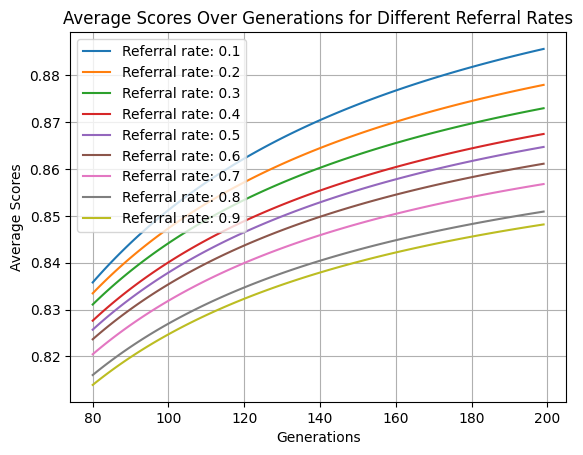

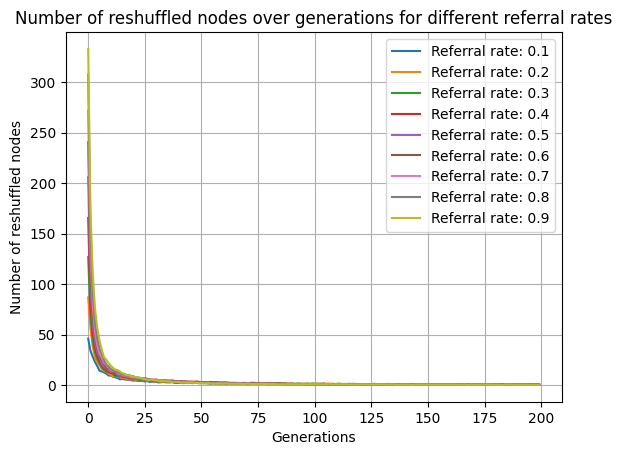

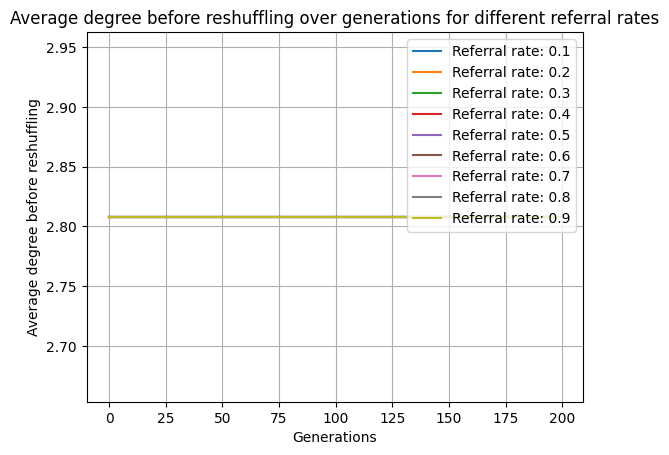

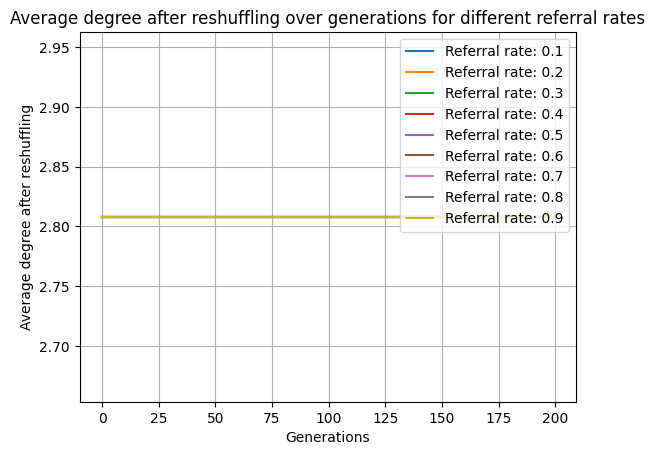

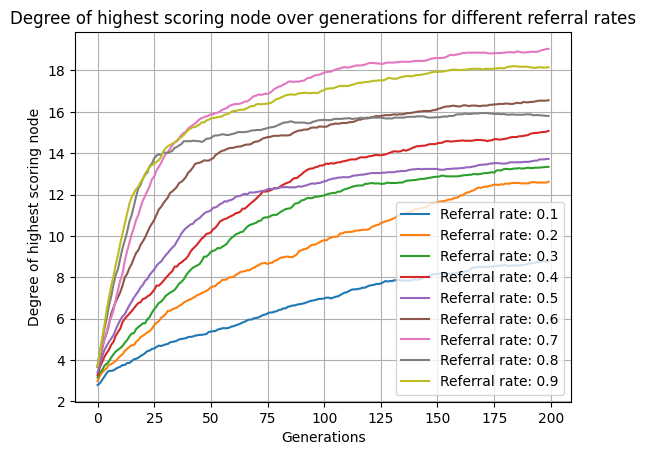

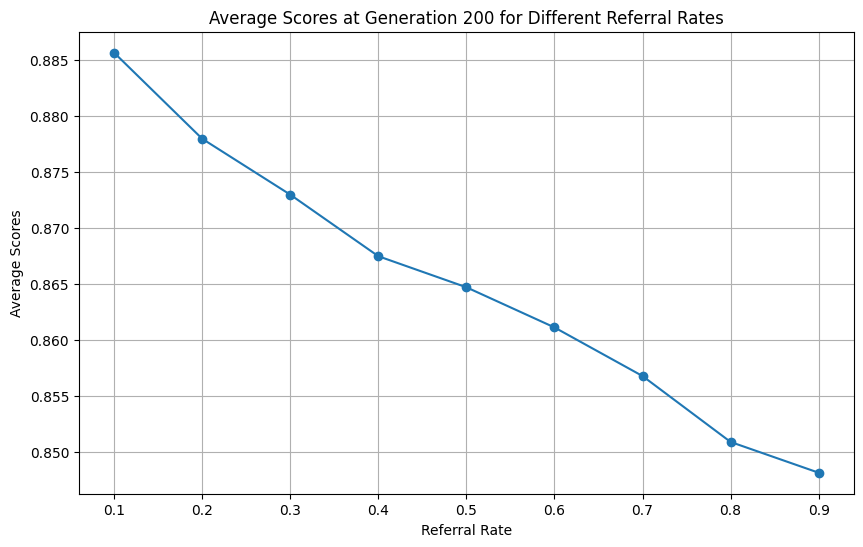

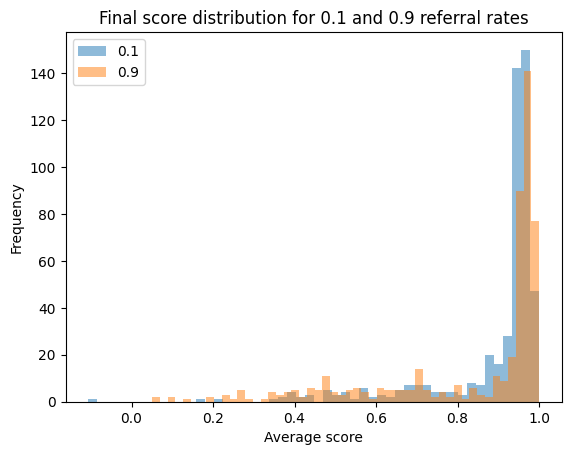

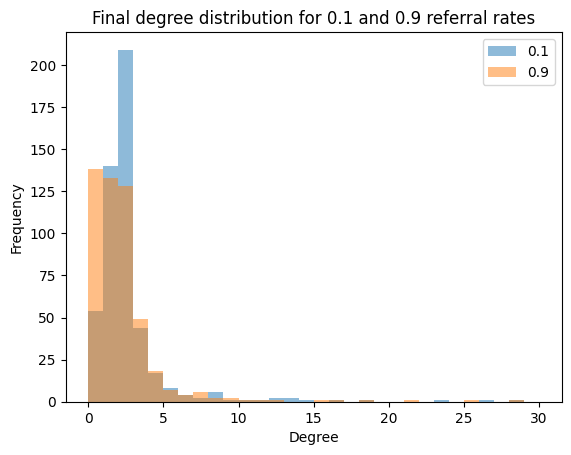

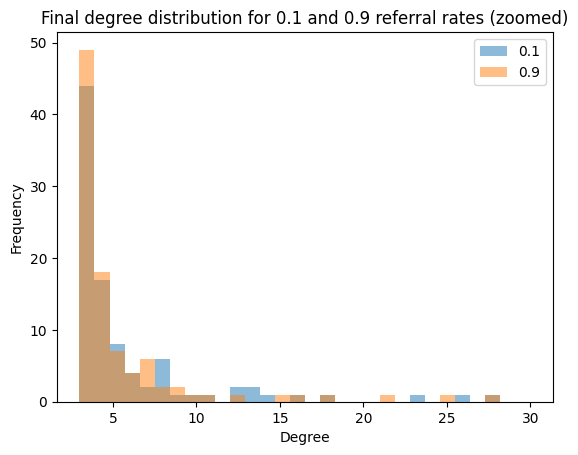

In [ ]:
plot_results_referral(base_parameters, pl_average_scores_all_runs, pl_average_degree_before, pl_average_degree_after, pl_number_of_reshuffled_nodes, pl_degree_highest_scoring_node, pl_degree_distribution, pl_final_scores_all_runs, referral_rates)

In [ ]:
print(max(pl_degree_distribution[0.1]))
print(max(pl_degree_distribution[0.9]))
print(np.mean(pl_degree_distribution[0.1]))
print(np.mean(pl_degree_distribution[0.9]))

152.0
223.0
2.808
2.808


# Uniform degree network
The network being initialized with a random uniform distribution seems to make the effect even more obvious


In [ ]:
degrees_uni = generate_uniform_degrees(n, 2.83)
edges_uni = configuration_model(degrees_uni)
A_uni = convert_to_adjacency_matrix(edges_uni, n)
base_parameters, uni_average_scores_all_runs, uni_average_degree_before, uni_average_degree_after, uni_number_of_reshuffled_nodes, uni_degree_highest_scoring_node, uni_degree_distribution, uni_final_scores_all_runs = run_simulation_referral(A_uni, num_generations, num_runs, referral_rates, restricted=False)

100%|██████████| 50/50 [03:42<00:00,  4.46s/it]


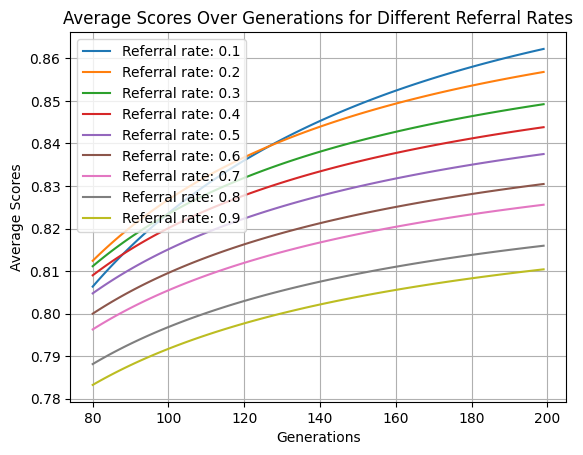

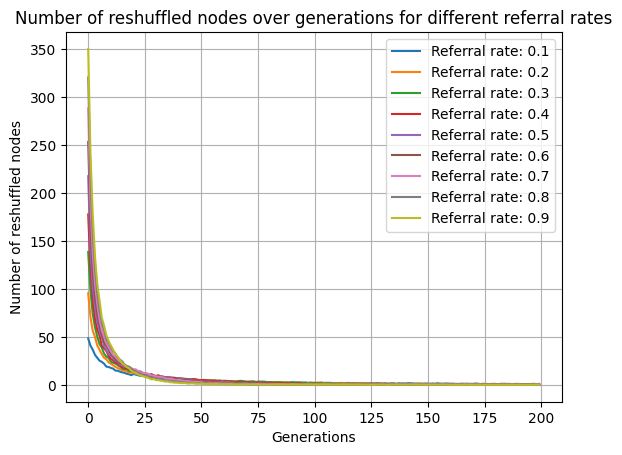

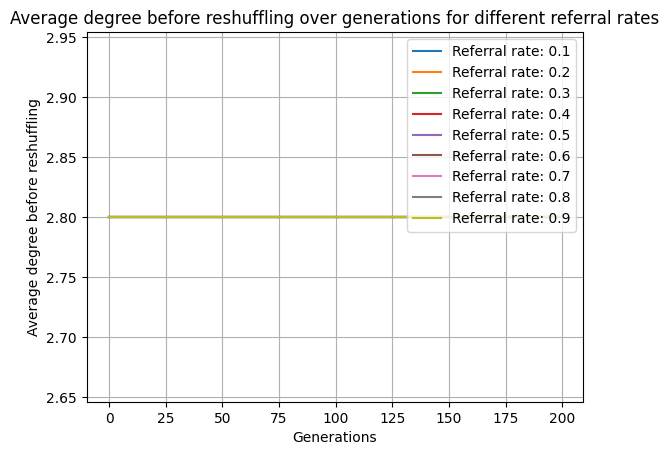

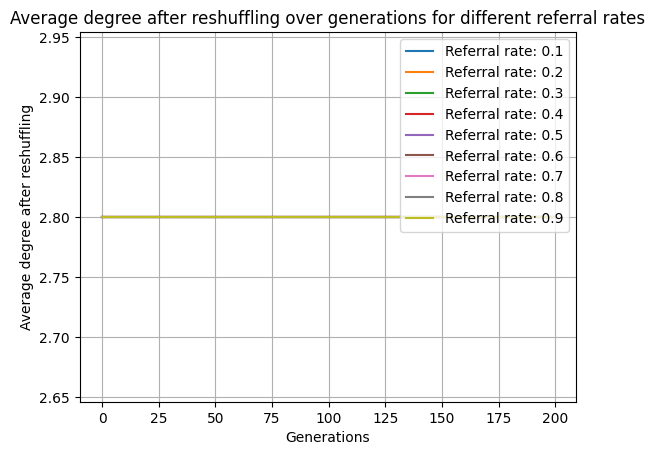

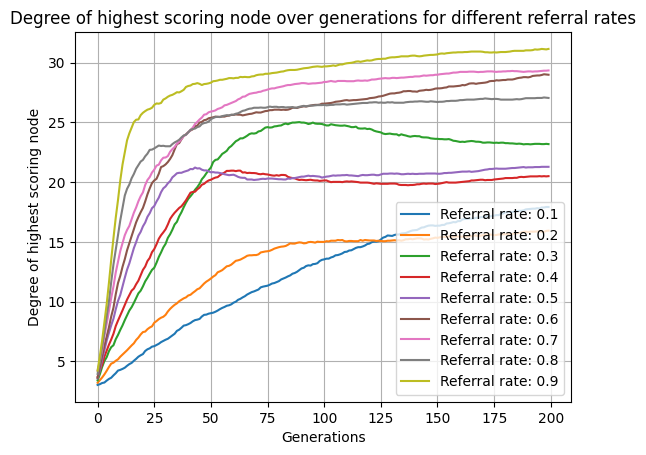

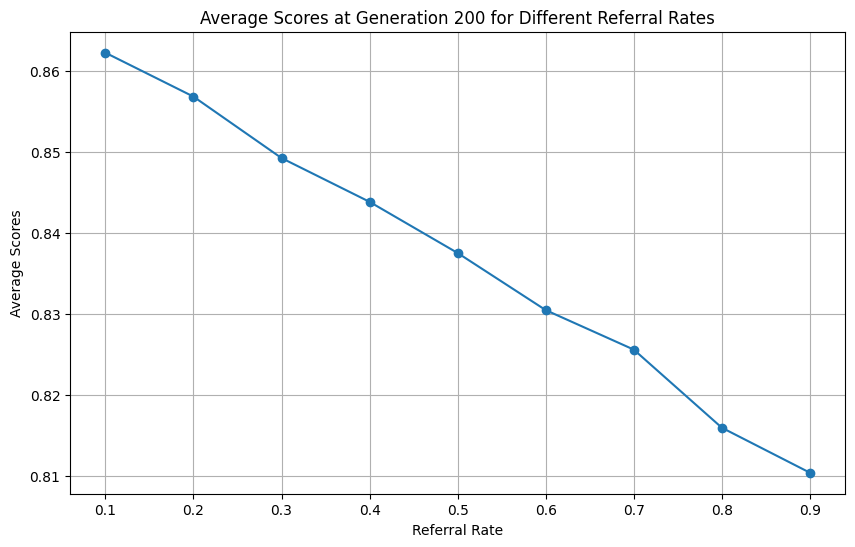

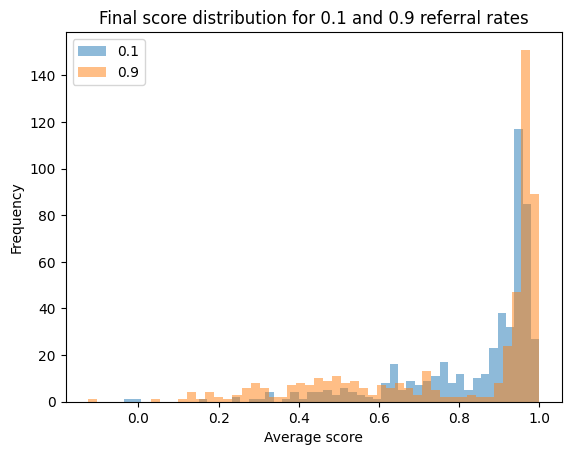

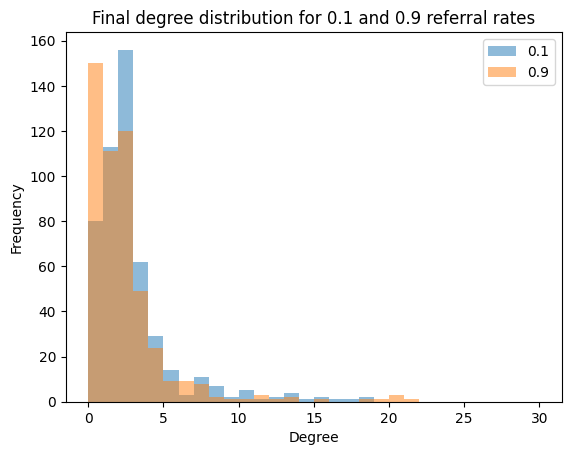

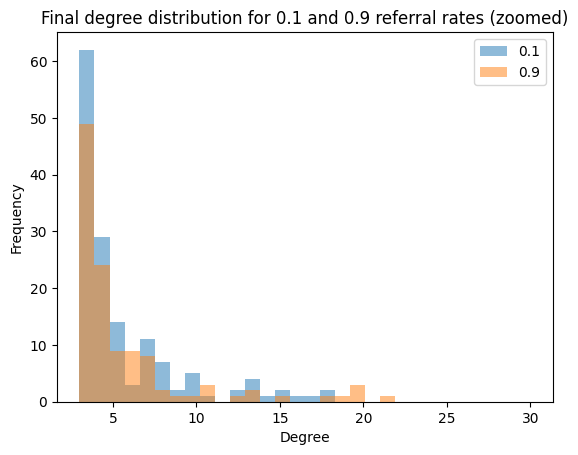

In [ ]:
plot_results_referral(base_parameters, uni_average_scores_all_runs, uni_average_degree_before, uni_average_degree_after, uni_number_of_reshuffled_nodes, uni_degree_highest_scoring_node, uni_degree_distribution, uni_final_scores_all_runs, referral_rates)

# Enforce minimum 2 degrees
THis seems to happen because some nodes get isolated and can never improve. Let's raise the bar so the random neighbour must have at least two nodes.

In [ ]:
base_parameters, pl_r_average_scores_all_runs, pl_r_average_degree_before, pl_r_average_degree_after, pl_r_number_of_reshuffled_nodes, pl_r_degree_highest_scoring_node, pl_r_degree_distribution, pl_r_final_scores_all_runs = run_simulation_referral(A, num_generations, num_runs, referral_rates, min_degree=2)

100%|██████████| 50/50 [04:39<00:00,  5.59s/it]


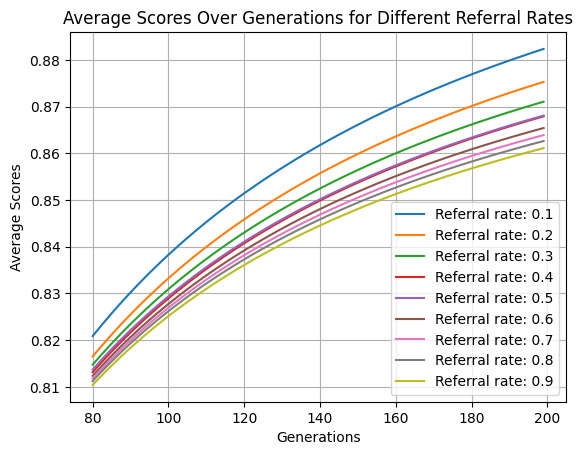

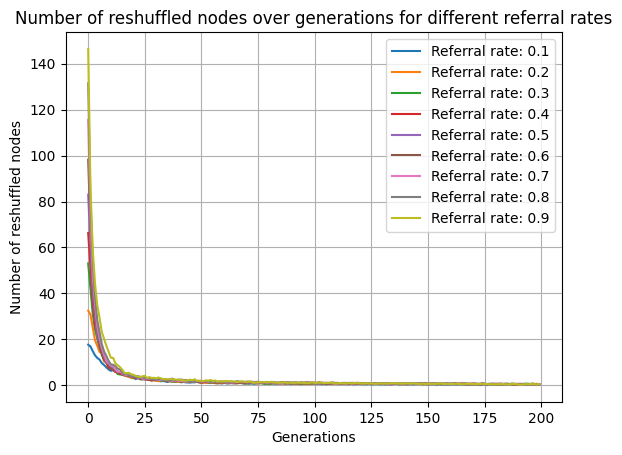

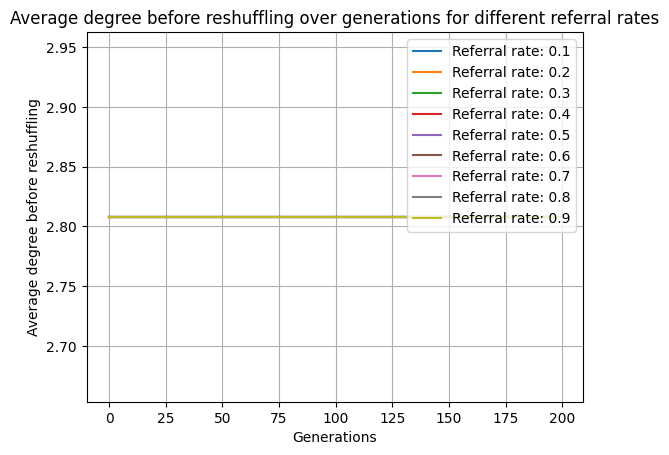

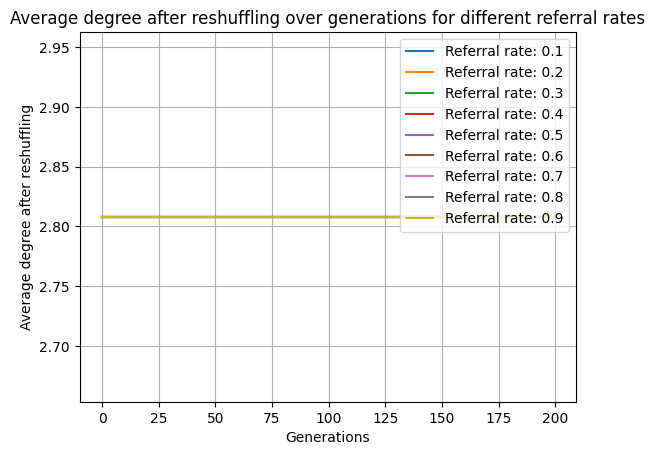

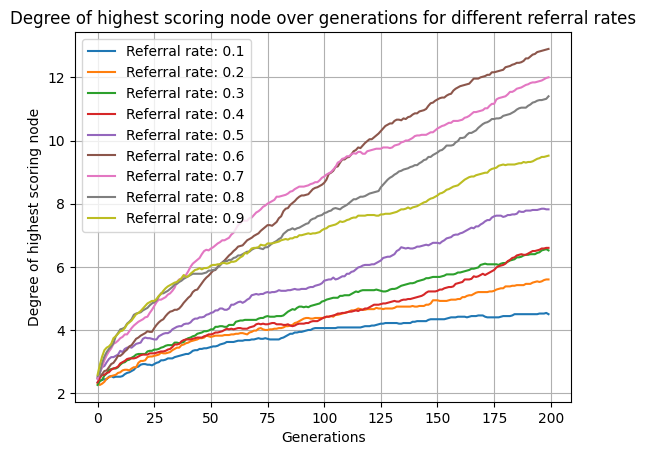

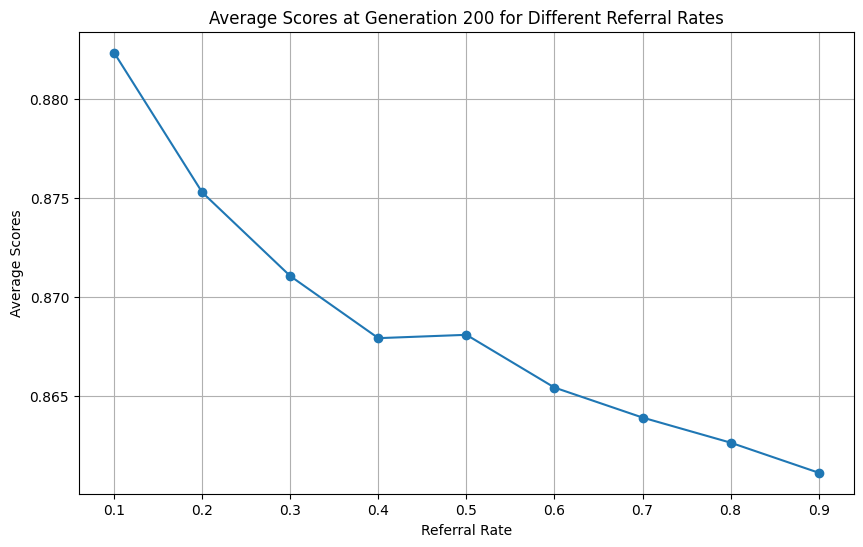

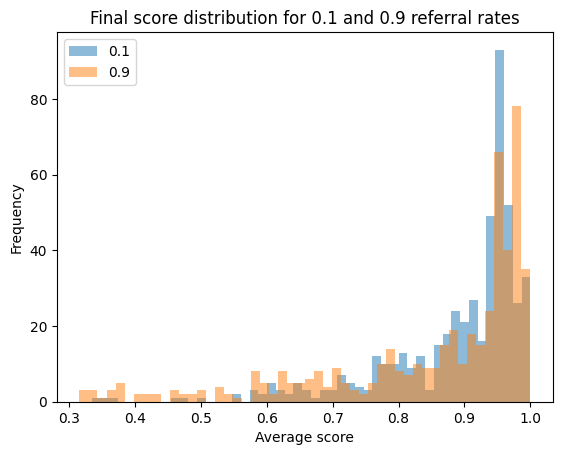

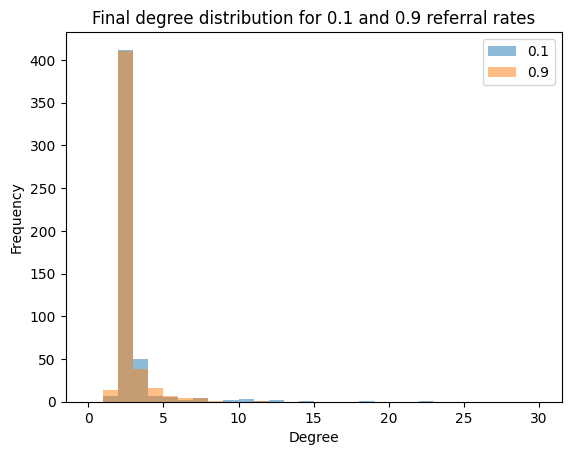

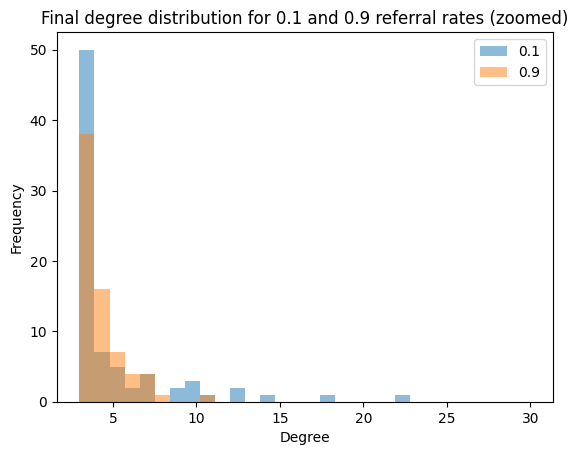

In [ ]:
plot_results_referral(base_parameters, pl_r_average_scores_all_runs, pl_r_average_degree_before, pl_r_average_degree_after, pl_r_number_of_reshuffled_nodes, pl_r_degree_highest_scoring_node, pl_r_degree_distribution, pl_r_final_scores_all_runs, referral_rates)

# Noisy

In [ ]:
# noisy
base_parameters, pl_n2_average_scores_all_runs, pl_n2_average_degree_before, pl_n2_average_degree_after, pl_n2_number_of_reshuffled_nodes, pl_n2_degree_highest_scoring_node, pl_n2_degree_distribution, pl_n2_final_scores_all_runs = run_simulation_referral(A, num_generations, num_runs, referral_rates, min_degree=2, noise=0.2)


100%|██████████| 50/50 [04:48<00:00,  5.77s/it]


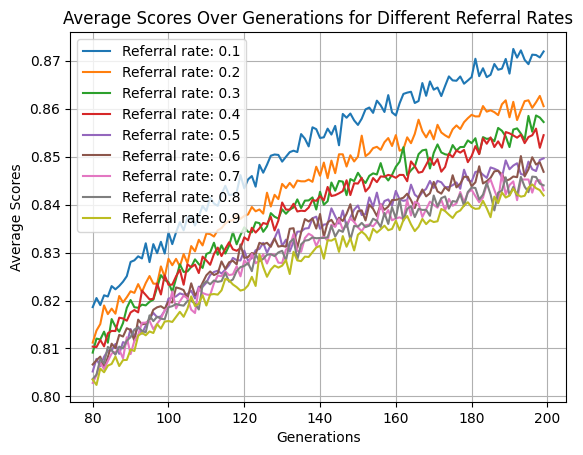

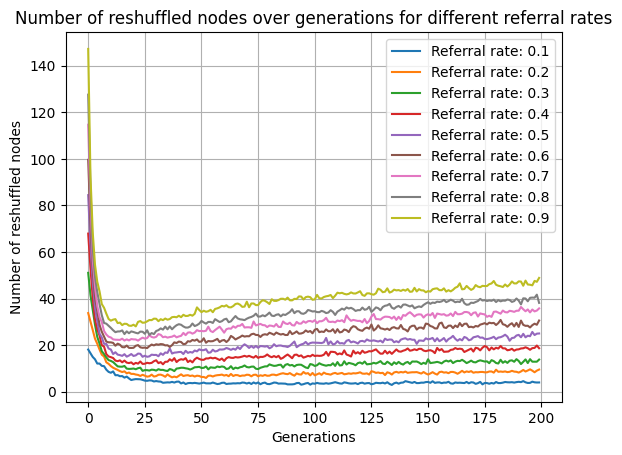

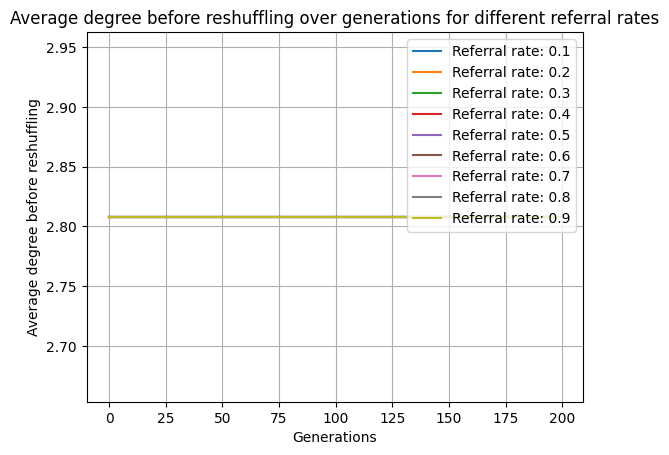

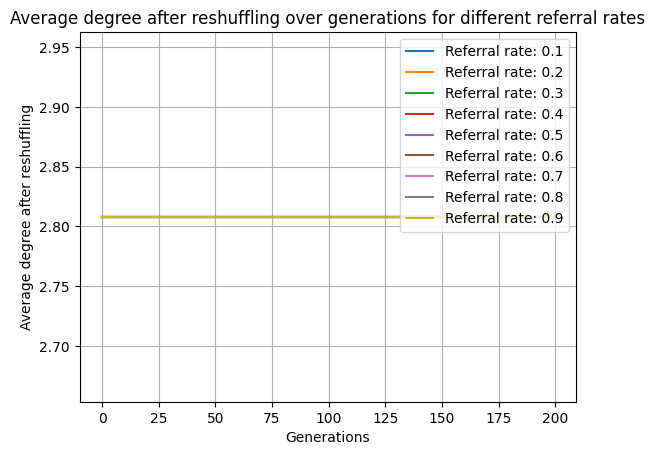

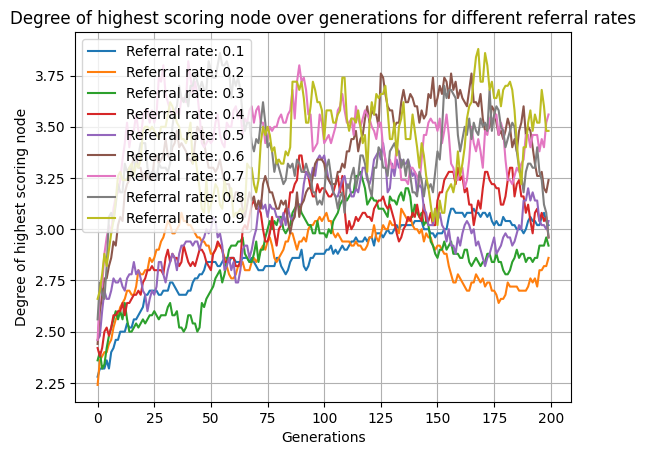

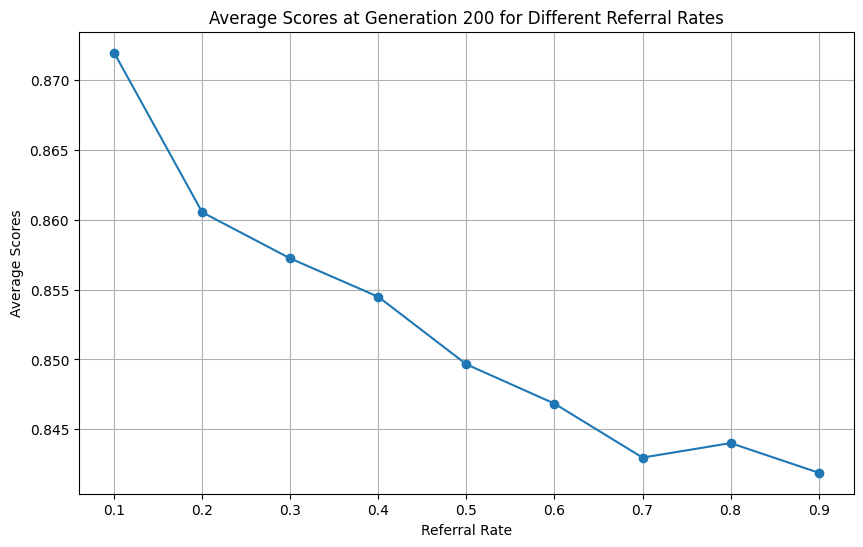

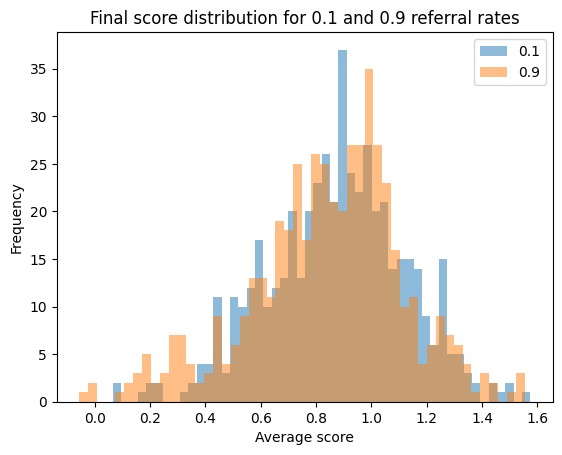

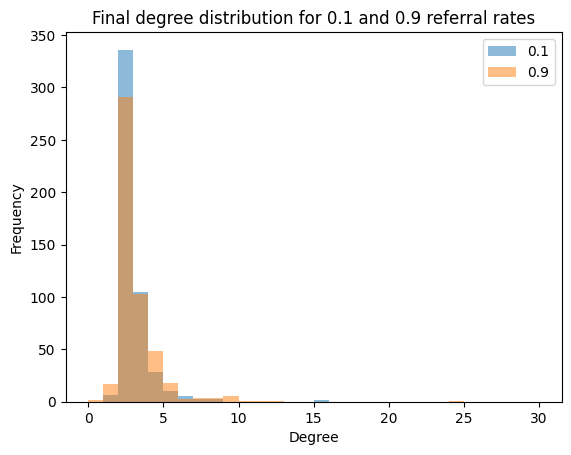

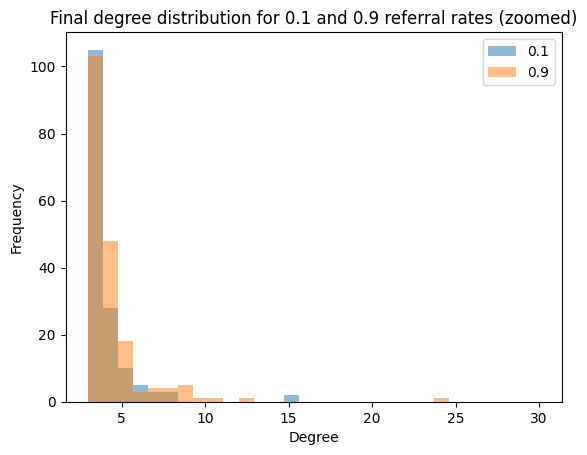

In [ ]:
plot_results_referral(base_parameters, pl_n2_average_scores_all_runs, pl_n2_average_degree_before, pl_n2_average_degree_after, pl_n2_number_of_reshuffled_nodes, pl_n2_degree_highest_scoring_node, pl_n2_degree_distribution, pl_n2_final_scores_all_runs, referral_rates)

In [ ]:
# noisy with noise = 0.5
base_parameters, pl_n5_average_scores_all_runs, pl_n5_average_degree_before, pl_n5_average_degree_after, pl_n5_number_of_reshuffled_nodes, pl_n5_degree_highest_scoring_node, pl_n5_degree_distribution, pl_n5_final_scores_all_runs = run_simulation_referral(A, num_generations, num_runs, referral_rates, min_degree=2, noise=0.5)


100%|██████████| 50/50 [04:44<00:00,  5.68s/it]


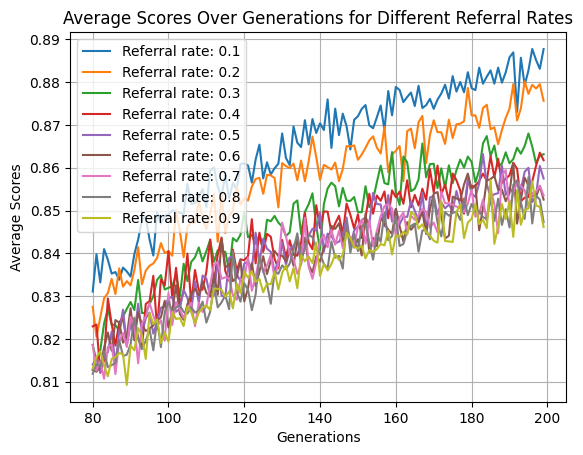

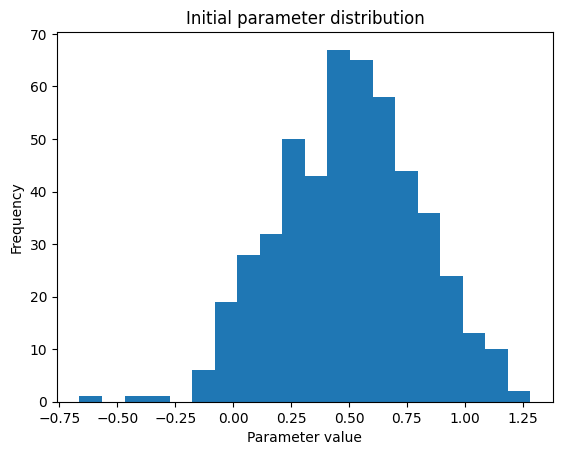

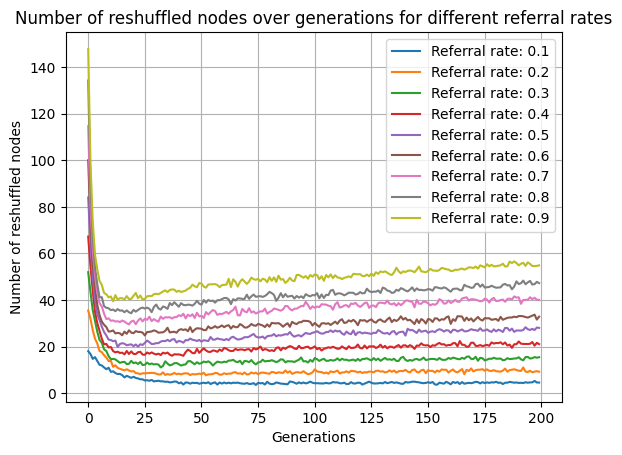

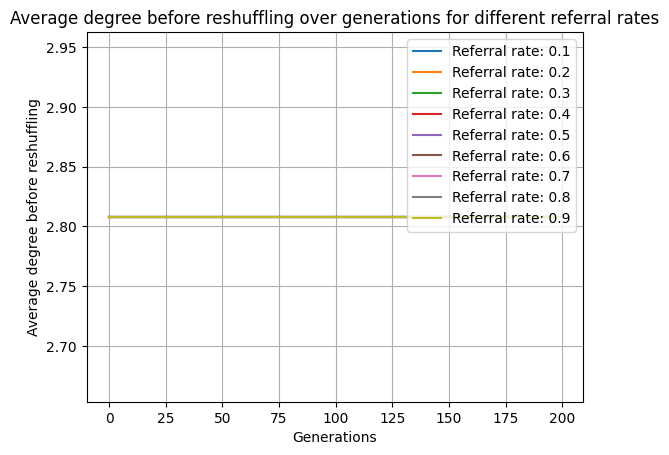

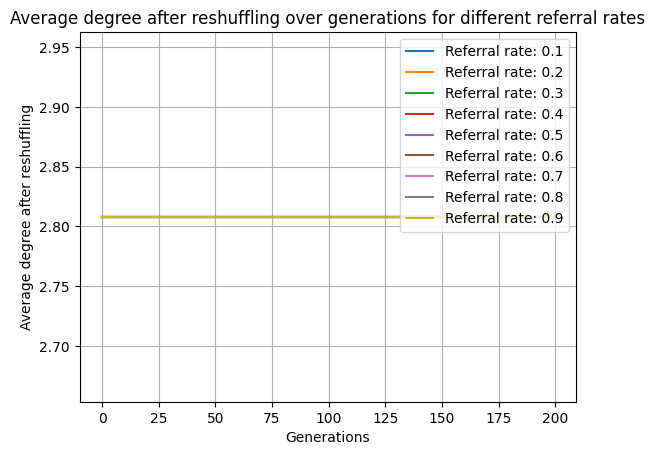

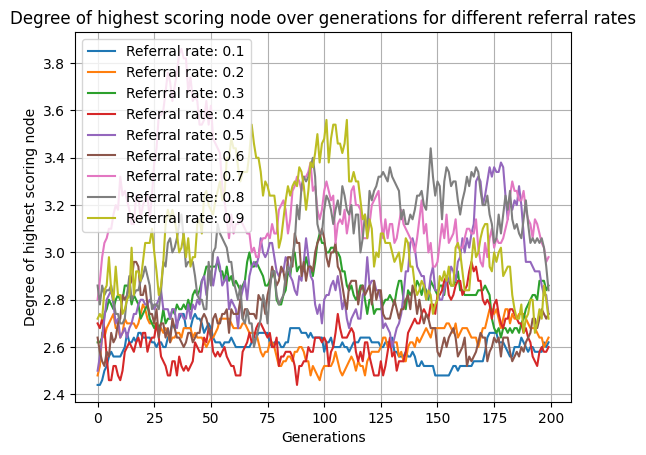

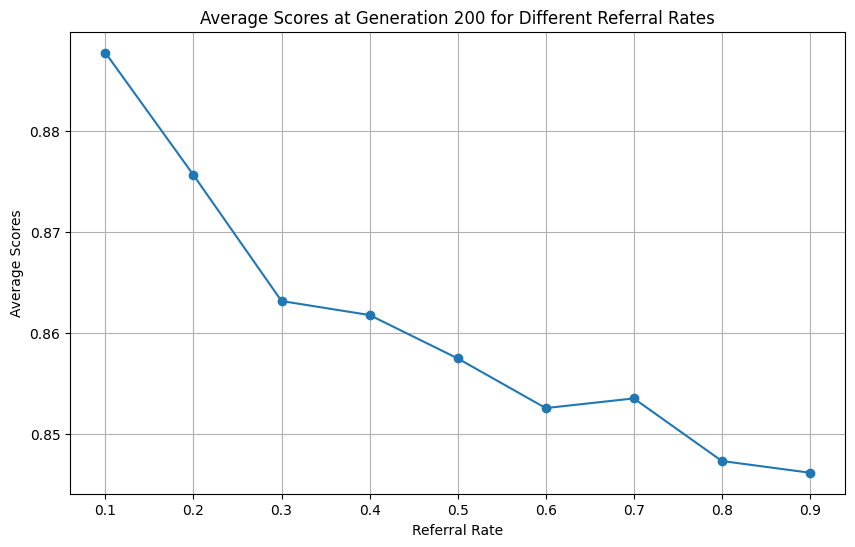

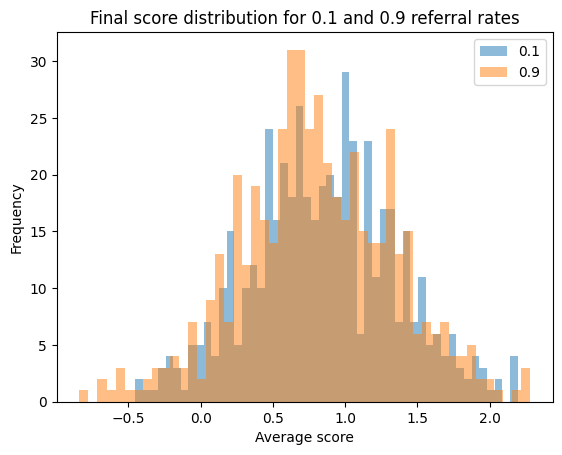

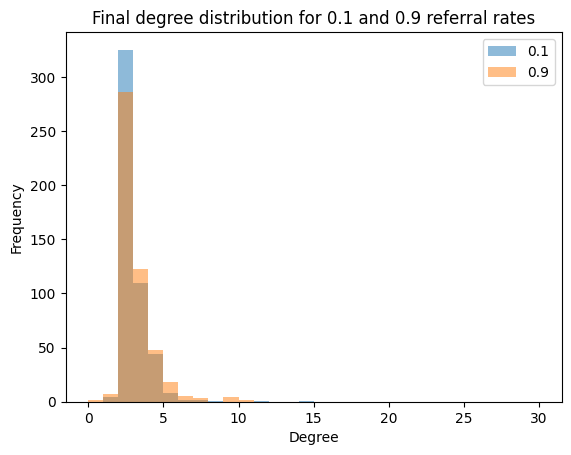

In [ ]:
plot_results_referral(base_parameters, pl_n5_average_scores_all_runs, pl_n5_average_degree_before, pl_n5_average_degree_after, pl_n5_number_of_reshuffled_nodes, pl_n5_degree_highest_scoring_node, pl_n5_degree_distribution, pl_n5_final_scores_all_runs, referral_rates)

In [ ]:
# Generate power-law distributed degree sequence with min degree 3
degrees_3 = generate_power_law_degrees(n, gamma, min_degree=3)
edges_3 = configuration_model(degrees_3)
A_3 = convert_to_adjacency_matrix(edges_3, n)

# noisy with noise = 0.5, restricted to 3
base_3_parameters, pl_r3_n5_average_scores_all_runs, pl_r3_n5_average_degree_before, pl_r3_n5_average_degree_after, pl_r3_n5_number_of_reshuffled_nodes, pl_r3_n5_degree_highest_scoring_node, pl_r3_n5_degree_distribution, pl_r3_n5_final_scores_all_runs = run_simulation_referral(A_3, num_generations, num_runs, referral_rates, min_degree=3, noise=0.5)


100%|██████████| 50/50 [04:45<00:00,  5.72s/it]


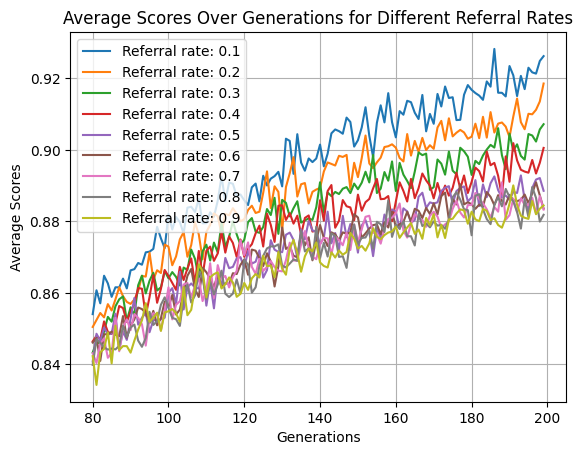

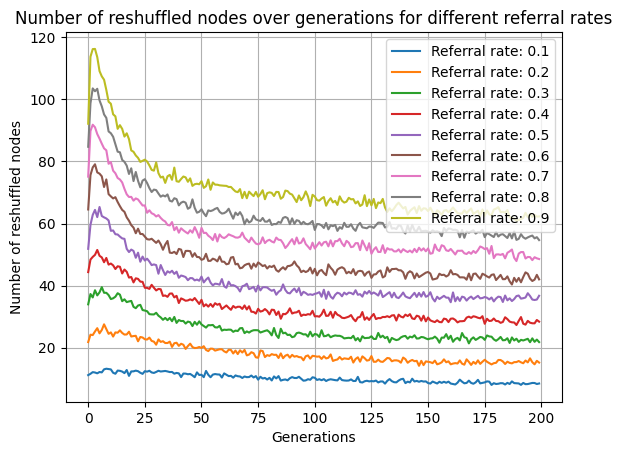

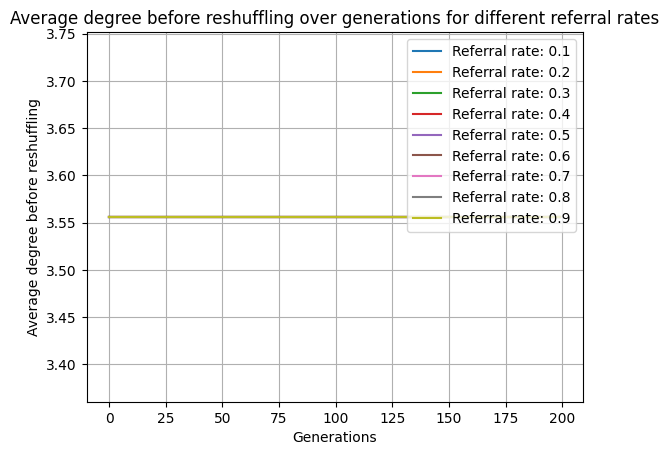

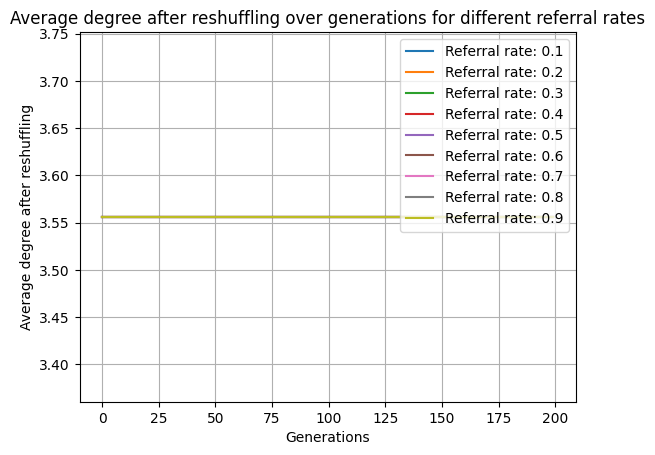

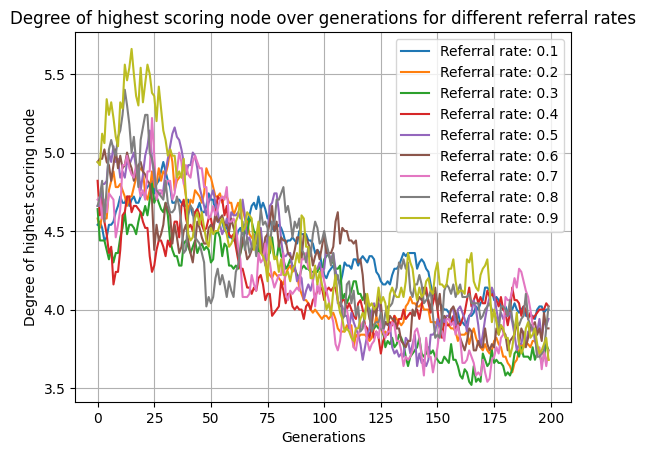

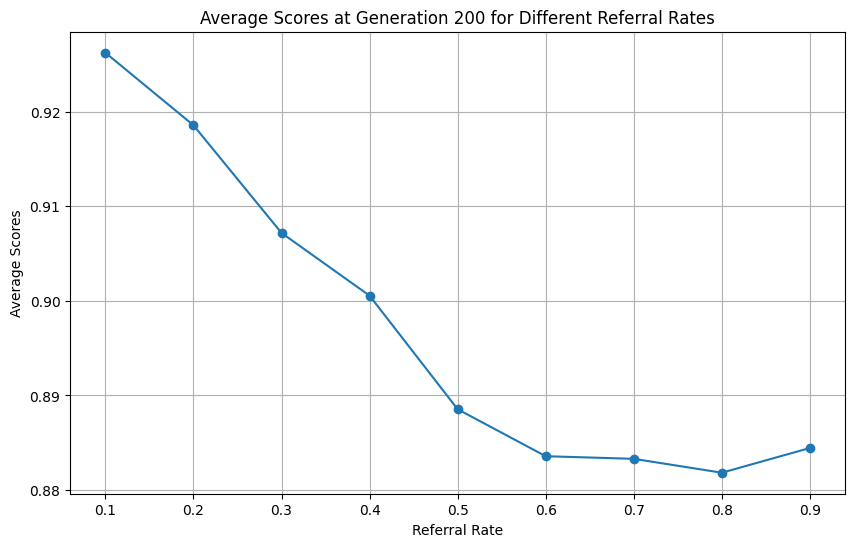

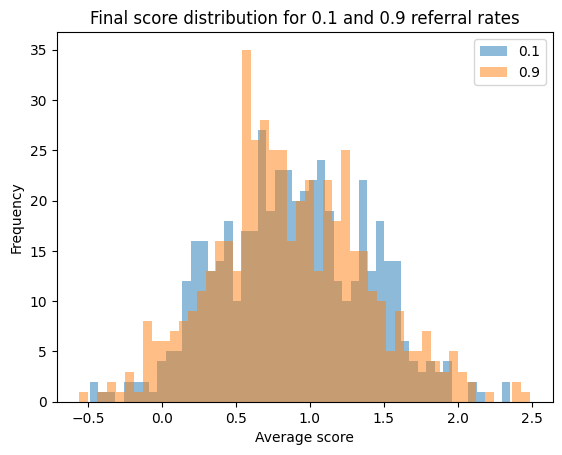

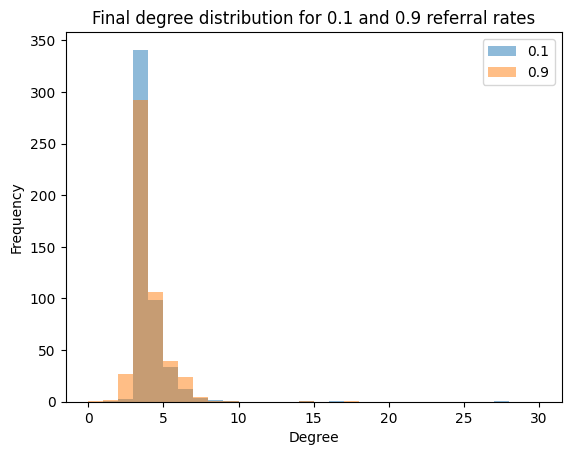

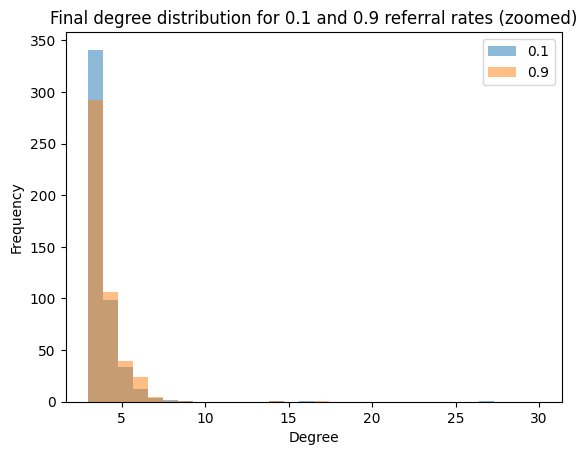

In [ ]:
plot_results_referral(base_3_parameters, pl_r3_n5_average_scores_all_runs, pl_r3_n5_average_degree_before, pl_r3_n5_average_degree_after, pl_r3_n5_number_of_reshuffled_nodes, pl_r3_n5_degree_highest_scoring_node, pl_r3_n5_degree_distribution, pl_r3_n5_final_scores_all_runs, referral_rates)